# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


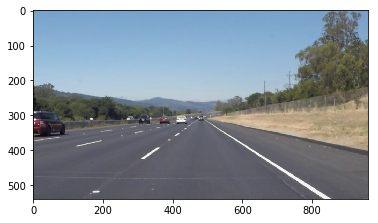

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
#     plt.imshow(mask)
#     plt.show()
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def draw_line(img, x, y, color=[255,0,0], thickness=20):
    if len(x) == 0:
        return
    
    # Fit line
    line_parameters = np.polyfit(x, y, 1)
    
    max_y = img.shape[0]
    m = line_parameters[0]
    b = line_parameters[1]
    print('m = ', m, 'b = ', b)
    
    y1 = max_y
    x1 = int((y1-b)/m)
    y2 = int((max_y/2)) + 60 # Restrict line to just below the horizon
    x2 = int((y2-b)/m)
    
    cv2.line(img, (x1,y1), (x2,y2), [255,0,0],4)
    
def draw_fitted_lines(img, lines, color=[255, 0, 0], thickness=20):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    # Left lane
    ll_x = []
    ll_y = []
    ll_gradient = []
    # Right lane
    rl_x = []
    rl_y = []
    rl_gradient = []
    
    # Sort lanes
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y1-y2)/(x1-x2)
            if(m < 0):
                ll_x.append(x1)
                ll_y.append(y1)
                ll_x.append(x2)
                ll_y.append(y2)
            else:
                rl_x.append(x1)
                rl_y.append(y1)
                rl_x.append(x2)
                rl_y.append(y2)  
    # Draw lanes
    draw_line(img, ll_x, ll_y, color, thickness)
    draw_line(img, rl_x, rl_y, [0,0,255], thickness)
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    draw_fitted_lines(line_img, lines,[0,0,255],20)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")



['solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

['solidWhiteCurve.jpg', 'solidYellowCurve2.jpg', 'solidWhiteRight.jpg', 'solidYellowLeft.jpg', 'solidYellowCurve.jpg', 'whiteCarLaneSwitch.jpg']

File: [ 960 x 540 ]  solidWhiteCurve.jpg
m =  -0.75596294427 b =  675.487227495
m =  0.562331085686 b =  39.1748762797

File: [ 960 x 540 ]  solidYellowCurve2.jpg
m =  -0.74416101039 b =  666.646190471
m =  0.584082412065 b =  34.5802657796

File: [ 960 x 540 ]  solidWhiteRight.jpg
m =  -0.678315145854 b =  636.793257187
m =  0.646133408435 b =  -2.58630386226

File: [ 960 x 540 ]  solidYellowLeft.jpg
m =  -0.696058895056 b =  641.098157913
m =  0.605421488372 b =  20.0502709969

File: [ 960 x 540 ]  solidYellowCurve.jpg
m =  -0.719861655486 b =  655.35694027
m =  0.605625262372 b =  22.8346004944

File: [ 960 x 540 ]  whiteCarLaneSwitch.jpg
m =  -0.771725717661 b =  683.278153978
m =  0.577814223189 b =  31.313843619


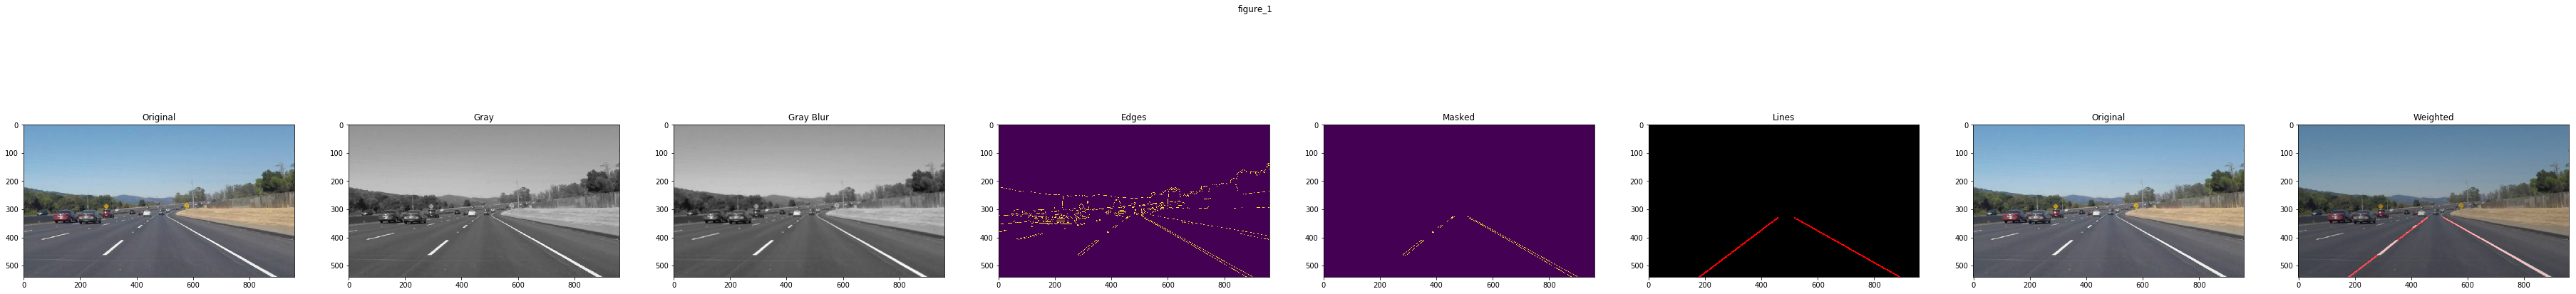

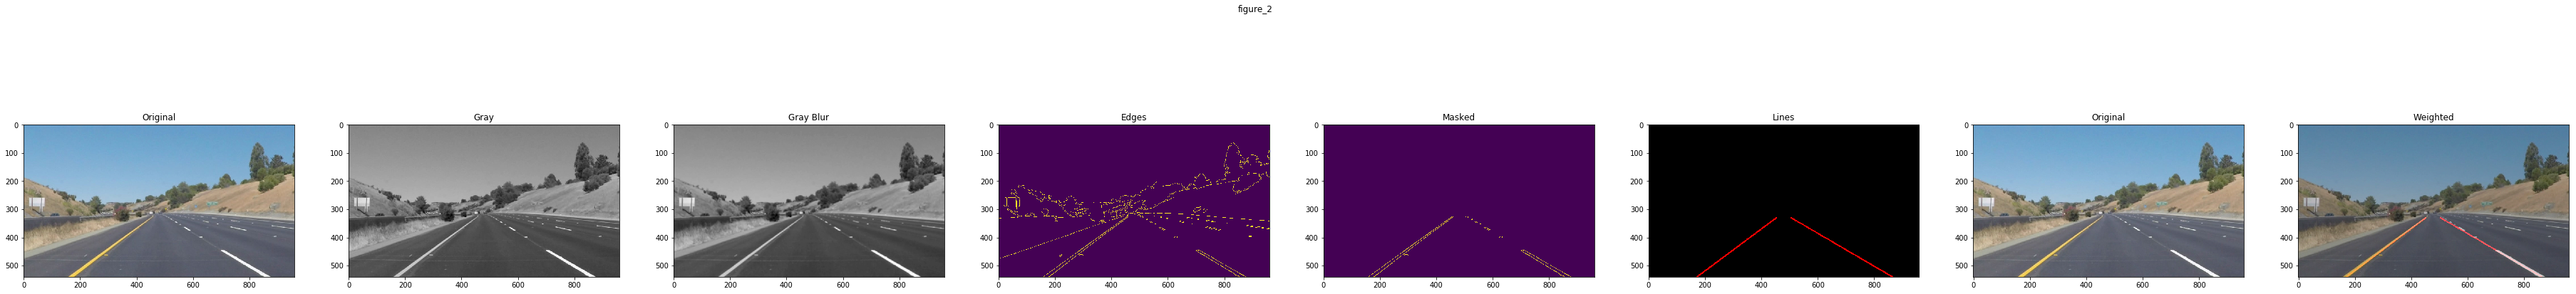

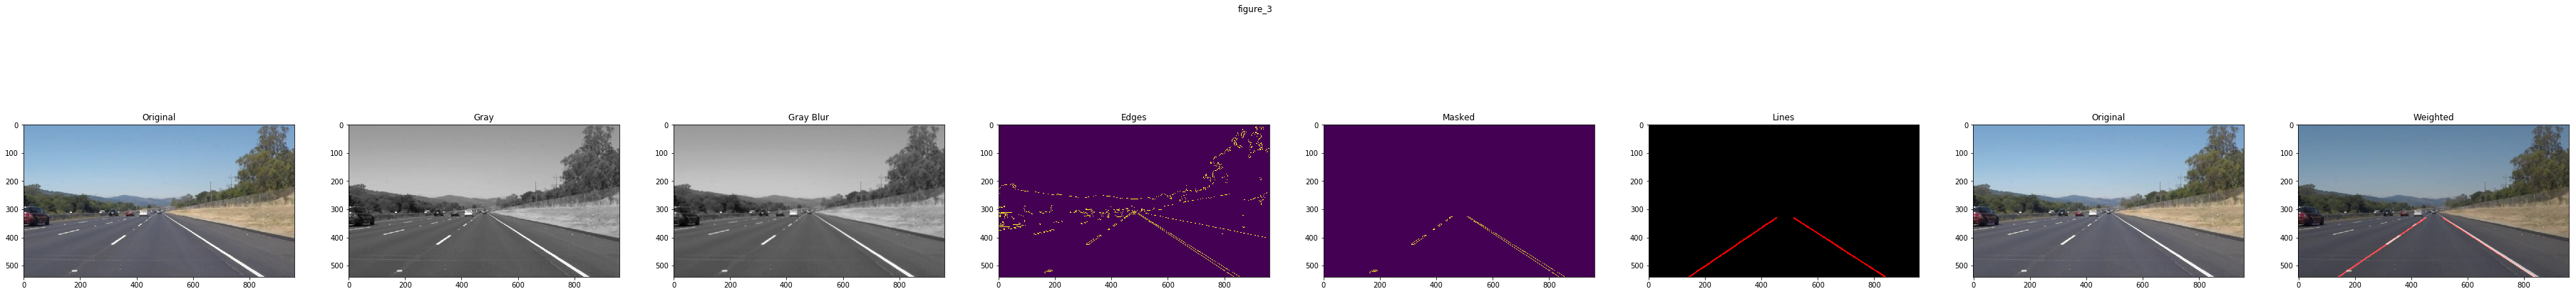

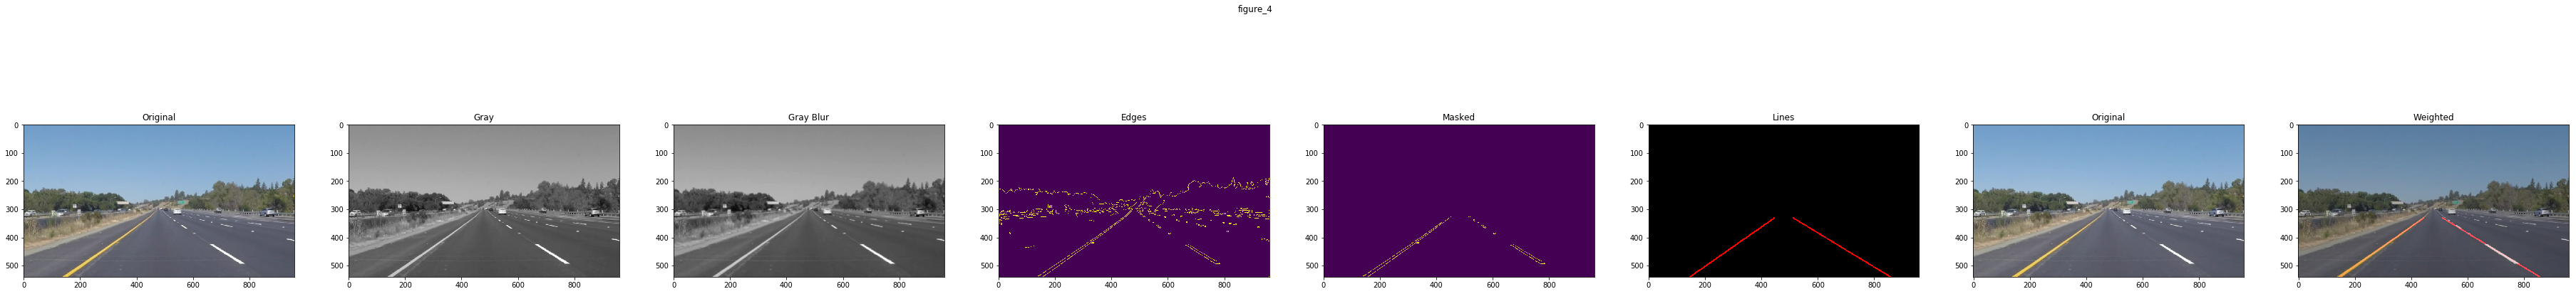

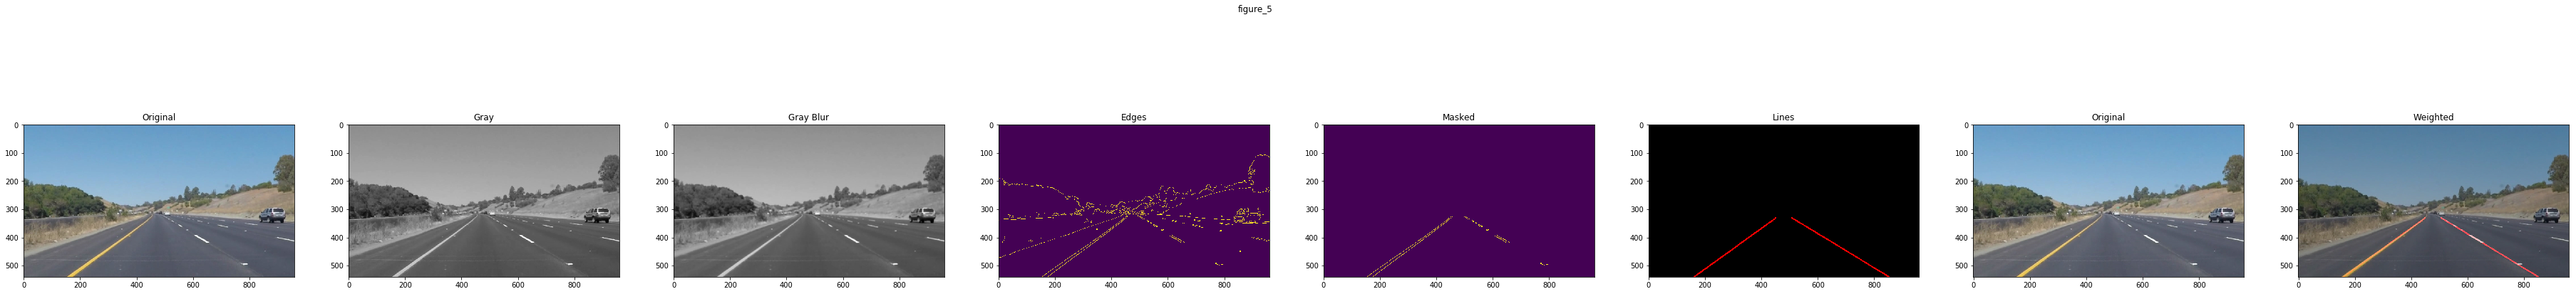

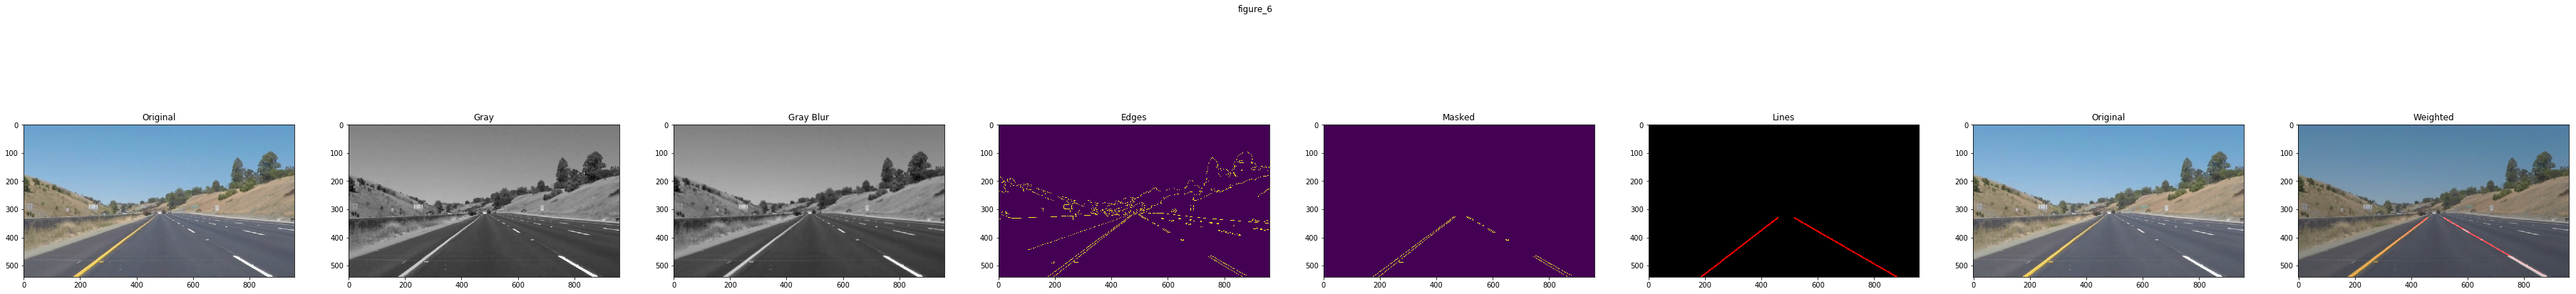

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import cv2
import numpy as np

DBG_LVL = 1
KERNEL_SIZE = 5
LOW_THRESHOLD = 50
HIGH_THRESHOLD = 150

image_files = []
images = os.listdir("test_images/")

if DBG_LVL:
    print (images)

for i,image in enumerate(images):
    # Setting up figure
#     fig = plt.figure(figsize=(100,50))
    fig = plt.figure(figsize=(64,8))
    FIG_ROWS = 1
    FIG_COLUMNS = 8
    
    # Image info
    img_original = mpimg.imread(os.path.join('test_images/', image))
    img = np.copy(img_original)
    #img = mpimg.imread(os.path.join('test_images/', image))
    ysize = img.shape[0]
    xsize = img.shape[1]
    if DBG_LVL:
        print('\nFile: [', xsize, 'x', ysize, '] ', image)
    
    # Convert to grayscal
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian smoothing
    img_blur = cv2.GaussianBlur(img_gray, (KERNEL_SIZE,KERNEL_SIZE), 0)

    # Canny edge detection
    img_edges = cv2.Canny(img_blur, LOW_THRESHOLD, HIGH_THRESHOLD)

    # Mask region of interest
    imshape = img.shape
    pt_topleft = (450, 325)
    pt_topright = (525, 325)
    pt_bottomleft = (125, imshape[0])
    pt_bottomright = (imshape[1]-50, imshape[0])
    vertices = np.array([[pt_bottomleft, pt_topleft, pt_topright, pt_bottomright]], dtype=np.int32)
    
    img_mask = region_of_interest(img_edges, vertices)
    
    # Hough transform and draw lines
    # Parameters
    rho = 1           # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10     # minimum number of votes (intersections in Hough grid cell)
                      # points in image space need to be associated with each line segment
    min_line_len = 20  # minimum number of pixels making up a line
    max_line_gap = 3  # maximum gap in pixels between connectable line segments
    
    img_lines = hough_lines(img_mask, rho, theta, threshold, min_line_len, max_line_gap)
    
    # Weighted
    img_weighted = weighted_img(img_lines, img)
    
    # Save figures
    fig.suptitle('figure_'+str(i+1))
    a = fig.add_subplot(FIG_ROWS,FIG_COLUMNS,1)
    a.set_title('Original')
    a.imshow(img)
    
    b = fig.add_subplot(FIG_ROWS,FIG_COLUMNS,2)
    b.imshow(img_gray, cmap='gray')
    b.set_title('Gray')
    mpimg.imsave(os.path.join('test_images_output/gray_'+ image), img_gray, cmap='gray')

    c = fig.add_subplot(FIG_ROWS,FIG_COLUMNS,3)
    c.imshow(img_blur, cmap='gray')
    c.set_title('Gray Blur')
    mpimg.imsave(os.path.join('test_images_output/blur_'+ image), img_blur, cmap='gray')
    
    d = fig.add_subplot(FIG_ROWS,FIG_COLUMNS,4)
    d.imshow(img_edges)
    d.set_title('Edges')
    mpimg.imsave(os.path.join('test_images_output/edge_'+ image), img_edges)

    e = fig.add_subplot(FIG_ROWS,FIG_COLUMNS,5)
    e.imshow(img_mask)
    e.set_title('Masked')
    mpimg.imsave(os.path.join('test_images_output/mask_'+ image), img_mask)
    
    f = fig.add_subplot(FIG_ROWS,FIG_COLUMNS,6)
    f.imshow(img_lines)
    f.set_title('Lines')
    mpimg.imsave(os.path.join('test_images_output/lines_'+ image), img_lines)
    
    g = fig.add_subplot(FIG_ROWS,FIG_COLUMNS,7)
    g.imshow(img)
    g.set_title('Original')
    
    h = fig.add_subplot(FIG_ROWS,FIG_COLUMNS,8)
    h.imshow(img_weighted)
    h.set_title('Weighted')
    
    plt.savefig('test_images_output/figure_'+str(i+1)+'.png')
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    DBG_LVL = 1
    KERNEL_SIZE = 5
    LOW_THRESHOLD = 50
    HIGH_THRESHOLD = 150

    img = np.copy(image)

    # Convert to grayscal
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian smoothing
    img_blur = cv2.GaussianBlur(img_gray, (KERNEL_SIZE,KERNEL_SIZE), 0)

    # Canny edge detection
    img_edges = cv2.Canny(img_blur, LOW_THRESHOLD, HIGH_THRESHOLD)

    # Mask region of interest
    imshape = img.shape
    pt_topleft = (450, 325)
    pt_topright = (525, 325)
    pt_bottomleft = (125, imshape[0])
    pt_bottomright = (imshape[1]-50, imshape[0])
    vertices = np.array([[pt_bottomleft, pt_topleft, pt_topright, pt_bottomright]], dtype=np.int32)

    img_mask = region_of_interest(img_edges, vertices)

    # Hough transform and draw lines
    # Parameters
    rho = 1           # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10     # minimum number of votes (intersections in Hough grid cell)
                      # points in image space need to be associated with each line segment
    min_line_len = 20  # minimum number of pixels making up a line
    max_line_gap = 3  # maximum gap in pixels between connectable line segments

    img_lines = hough_lines(img_mask, rho, theta, threshold, min_line_len, max_line_gap)

    # Weighted
    img_weighted = weighted_img(img_lines, img)
    return img_weighted

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

m =  -0.727771877442 b =  654.261026391
m =  0.604008006298 b =  16.2234391665
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  2%|▏         | 4/222 [00:00<00:05, 39.93it/s]

m =  -0.727771877442 b =  654.261026391
m =  0.604008006298 b =  16.2234391665
m =  -0.730043541364 b =  654.914731495
m =  0.620071950344 b =  7.29691724481
m =  -0.742514011583 b =  658.421430566
m =  0.609618230826 b =  14.5240060557
m =  -0.731159330659 b =  653.764617532
m =  0.623699893471 b =  3.59662449246
m =  -0.68 b =  632.48
m =  0.613233868124 b =  10.1623807403
m =  -0.669163031849 b =  630.7106411
m =  0.624598117585 b =  2.22551057856
m =  -0.687865422095 b =  636.474510206
m =  0.62019138793 b =  6.00566960603
m =  -0.694141298105 b =  640.206777714
m =  0.602182961371 b =  16.3318413234


  4%|▍         | 9/222 [00:00<00:05, 41.33it/s]

m =  -0.691818930041 b =  639.614683128
m =  0.177164038595 b =  314.86531027


  6%|▋         | 14/222 [00:00<00:04, 42.55it/s]

m =  -0.717232745482 b =  649.335837143
m =  0.616850933624 b =  11.1925755744
m =  -0.717584863662 b =  651.921257652
m =  0.629036029229 b =  6.59173847162
m =  -0.684519144242 b =  643.75105228
m =  0.630248677424 b =  6.34258917016
m =  -0.719156850589 b =  652.138251705
m =  0.621554321131 b =  11.9425549005
m =  -0.708548664701 b =  646.144495149
m =  0.628880260406 b =  6.71769475455
m =  -0.672763582882 b =  637.27310676
m =  0.628272936585 b =  5.1106530041
m =  -0.693317485152 b =  639.737841979
m =  0.647551522786 b =  -7.83363951293
m =  -0.71920387305 b =  648.569661108
m =  0.650247909825 b =  -9.92252895351
m =  -0.664371257485 b =  627.043413174
m =  0.644025301988 b =  -5.65843594684
m =  -0.674519753534 b =  630.640811888
m = 

 11%|█         | 24/222 [00:00<00:04, 43.61it/s]

 0.646885415926 b =  -6.77812710371
m =  -0.662040096938 b =  629.259748843
m =  0.644791603075 b =  -4.77385120691
m =  -0.651388591419 b =  628.573927322
m =  0.642266651916 b =  -0.991323303129
m =  -0.681145584726 b =  640.629594272
m =  0.634739764249 b =  3.7987342521
m =  -0.690176012595 b =  642.445750975
m =  0.625827129121 b =  6.33617311357
m =  -0.690268858169 b =  640.277021879
m =  0.640157494339 b =  -0.670341404167
m =  -0.697118759653 b =  642.539302405
m =  0.656929183155 b =  -11.1411291607
m =  -0.671240844008 b =  635.512485283
m =  0.638352854065 b =  -0.0287406131288
m =  -0.689842058614 b =  644.510817605
m =  0.649026029704 b =  -6.42714837759


 15%|█▌        | 34/222 [00:00<00:04, 44.06it/s]

m =  -0.707454969803 b =  645.554532149
m =  0.642549214688 b =  -1.81394056564
m =  -0.67290886392 b =  631.086142322
m =  0.636448294958 b =  0.548751207819
m =  -0.655896274954 b =  626.401008438
m =  0.637163185945 b =  -0.410134278708
m =  -0.658096280088 b =  627.697757112
m =  0.642009871254 b =  -4.00448519891
m =  -0.661003748235 b =  628.978435477
m =  0.643484681501 b =  -3.79547859968
m =  -0.683590453364 b =  637.034533977
m =  0.62490737019 b =  5.00634692793
m =  -0.656886200515 b =  629.353135016
m =  0.641532964409 b =  -3.12521461263
m =  -0.716247557479 b =  649.467521321
m =  0.629579725743 b =  3.97545069659
m =  -0.694600845735 b =  642.85769689
m =  0.632872898449 b =  1.76129227918


 18%|█▊        | 39/222 [00:00<00:04, 43.77it/s]

m =  -0.679282659317 b =  641.029993011
m =  0.627072683862 b =  6.1511477292
m =  -0.706227359969 b =  647.35960741
m =  0.634714498287 b =  1.84567715491
m =  -0.693554373376 b =  646.038104664
m =  0.63605451485 b =  0.0450857167081
m =  -0.70412723042 b =  644.610944256
m =  0.654934396587 b =  -11.7926274844
m =  -0.679107941598 b =  634.847265592
m =  0.659910410642 b =  -15.2960446446
m =  -0.674336443518 b =  632.257360268
m =  0.639673072747 b =  -2.57511702213
m =  -0.688362465501 b =  638.312787489
m =  0.64734116095 b =  -8.43933705471


 20%|█▉        | 44/222 [00:01<00:05, 29.73it/s]

m =  -0.686693463084 b =  636.357732177
m =  0.643268898675 b =  -6.30906480433
m =  -0.700823421775 b =  642.380786825
m =  0.662000157386 b =  -17.9572814665
m =  -0.679257362356 b =  635.025128041
m =  0.660811388471 b =  -15.5982004519
m =  -0.699308129166 b =  642.07365199
m =  0.645181223058 b =  -8.00420373787


 22%|██▏       | 48/222 [00:01<00:07, 23.14it/s]

m =  -0.704115928322 b =  642.794749672
m =  0.64348039855 b =  -6.09120541273
m =  -0.681986044432 b =  636.724824584
m =  0.652747361439 b =  -10.9729265918
m =  -0.712750550533 b =  645.144602349
m =  0.647976828463 b =  -8.69124223663
m =  -0.704319559513 b =  642.973270948
m =  0.643658856974 b =  -6.47292771257


 24%|██▍       | 54/222 [00:01<00:09, 18.53it/s]

m =  -0.687659102737 b =  637.123796181
m =  0.651043559825 b =  -10.5335680339
m =  -0.685887121768 b =  635.473756121
m =  0.642595644258 b =  -4.56204295009
m =  -0.697616506581 b =  639.600853789
m =  0.651752642626 b =  -10.0346294415
m =  -0.714364640884 b =  645.849723757
m =  0.640725608169 b =  -2.8353370962


 26%|██▌       | 57/222 [00:02<00:09, 16.91it/s]

m =  -0.722222222222 b =  649.333333333
m =  0.645758879684 b =  -3.27969678563
m =  -0.694791483892 b =  638.28961392
m =  0.640199806072 b =  -1.09336707629
m =  -0.676997677218 b =  631.759159729
m =  0.653451259756 b =  -7.93107469017
m =  -0.700442823652 

 27%|██▋       | 61/222 [00:02<00:10, 15.77it/s]

b =  639.585504038
m =  0.64874265417 b =  -3.64124456584
m =  -0.655337361531 b =  627.196424975
m =  0.65217854467 b =  -7.7560019317
m =  -0.662309892618 b =  628.748490864
m =  0.646293313428 b =  -3.07856001676


 28%|██▊       | 63/222 [00:02<00:10, 15.46it/s]

m =  -0.654769492916 b =  626.943554953
m =  0.650119436924 b =  -5.58660684293
m =  -0.647047869699 b =  626.850941007
m =  0.645572054069 b =  -3.37217261471
m =  -0.687979869669 b =  634.724949997
m =  0.655092641528 b =  -6.88094636381
m =  -0.62899658154 b =  614.053891011
m =  0.658679725153 b =  -9.13806228608


 30%|███       | 67/222 [00:02<00:09, 15.62it/s]

m =  -0.641176470588 b =  617.529411765
m =  0.659176250282 b =  -9.97767581399
m =  -0.691474194468 b =  636.970630168
m =  0.644509996422 b =  -3.60151941939
m =  -0.694974874372 b =  637.448743719
m =  0.645619996422 b =  -4.25949659764
m =  -0.693221041005 b =  637.498964517
m =  0.64588963839 b =  -2.53358352394


 32%|███▏      | 71/222 [00:02<00:09, 15.74it/s]

m =  -0.708604278579 b =  642.389124493
m =  0.665449539821 b =  -13.0775094075
m =  -0.69269376337 b =  637.488645713
m =  0.652172584614 b =  -6.09966472208
m =  -0.702165956681 b =  639.254934901
m =  0.658399139245 b =  -11.1272124273
m =  -0.695820043646 b =  638.05911113
m =  0.665765076599 b =  -15.1479953595


 34%|███▍      | 75/222 [00:03<00:09, 15.27it/s]

m =  -0.698331042896 b =  639.065861707
m =  0.663824838339 b =  -13.3863741581
m =  -0.69254832384 b =  636.92524979
m =  0.671788596404 b =  -16.0116358181
m =  -0.690894759447 b =  635.101726932
m =  0.666962112902 b =  -14.4332646188
m =  -0.683650877795 b =  632.428596672
m =  0.672731180077 b =  -16.7829372353


 36%|███▌      | 79/222 [00:03<00:09, 15.72it/s]

m =  -0.668930390492 b =  626.487266553
m =  0.658919615545 b =  -7.89040091219
m =  -0.655151515152 b =  622.466666667
m =  0.687439584388 b =  -25.1917989823
m =  -0.673267326733 b =  628.420792079
m =  0.680287633993 b =  -20.8304316805
m =  -0.665875840253 b =  625.903123764
m =  0.670095679895 b =  -14.3888153836


 37%|███▋      | 83/222 [00:03<00:08, 15.70it/s]

m =  -0.673076923077 b =  628.538461538
m =  0.669022490349 b =  -15.6242906947
m =  -0.671707317073 b =  628.012195122
m =  0.673037402336 b =  -17.1024911789
m =  -0.688699916528 b =  632.798309683
m =  0.684692083761 b =  -23.8595151371
m = 

 39%|███▉      | 87/222 [00:03<00:08, 15.50it/s]

 -0.677175612298 b =  630.230849401
m =  0.686343691317 b =  -25.6245610585
m =  -0.676355703483 b =  630.579600424
m =  0.68098937641 b =  -21.8568849098
m =  -0.671706135948 b =  629.911061241
m =  0.685961788706 b =  -25.1017926518
m =  -0.67963127547 b =  631.731260297
m =  0.675292963733 b =  -18.1950873299


 41%|████      | 91/222 [00:04<00:08, 15.43it/s]

m =  -0.683307217835 b =  632.538971486
m =  0.681116024406 b =  -20.3551141629
m =  -0.670588235294 b =  628.344117647
m =  0.687462474388 b =  -25.2910840124
m =  -0.653100775194 b =  623.503875969
m =  0.691312493005 b =  -26.3052045211
m =  -0.677215189873 b =  632.566455696
m =  0.678182891163 b =  -19.784078583


 43%|████▎     | 95/222 [00:04<00:08, 14.89it/s]

m =  -0.711398963731 b =  644.135751295
m =  0.69040515831 b =  -26.6500978411
m =  -0.667750425763 b =  629.519430252
m =  0.695260029096 b =  -30.0549253076
m =  -0.672 b =  630.944
m =  0.69249351679 b =  -29.731896566


 44%|████▎     | 97/222 [00:04<00:08, 15.09it/s]

m =  -0.677921604376 b =  631.732762078
m =  0.678139612793 b =  -21.6831848622
m =  -0.675414967034 b =  631.448010467
m =  0.700403483776 b =  -36.9034877012
m =  -0.678269062612 b =  631.972486392
m =  0.710502760541 b =  -43.0348023648
m =  -0.677501622858 b =  631.219637376
m =  0.699231449685 b =  -37.5778210784


 45%|████▌     | 101/222 [00:04<00:07, 15.72it/s]

m =  -0.681885856079 b =  631.035235732
m =  0.701984448383 b =  -39.5543976656
m =  -0.668503380765 b =  628.824654355
m =  0.710267497614 b =  -45.2016878399
m =  -0.638278388278 b =  617.386446886
m =  0.704633033541 b =  -38.4878905964
m =  -0.607131120605 b =  606.754682879
m =  0.695152694941 b =  -32.8458755104


 47%|████▋     | 105/222 [00:05<00:07, 15.13it/s]

m =  -0.59532595326 b =  604.518757688
m =  0.689286189615 b =  -28.9634832114
m =  -0.615500125136 b =  611.408192208
m =  0.687180950602 b =  -28.1971487903
m =  -0.624808105619 b =  615.344795824
m =  0.682393392264 b =  -26.090514086
m =  -0.639309541459 b =  620.86935649
m =  0.677522406168 b =  -24.4363935528


 49%|████▉     | 109/222 [00:05<00:07, 15.42it/s]

m =  -0.654238738899 b =  625.966510931
m =  0.674808273396 b =  -21.6584825187
m =  -0.668070584875 b =  633.054135937
m =  0.676582481104 b =  -22.9929157857
m =  -0.667507890477 b =  631.684070285
m =  0.684314324537 b =  -29.1503985569
m =  -0.651622405153 b =  627.976208636
m =  0.676755213379 b =  -23.4250917759


 51%|█████     | 113/222 [00:05<00:06, 15.76it/s]

m =  -0.694183398768 b =  638.114430209
m =  0.671291585256 b =  -19.9941274596
m =  -0.686719750602 b =  636.184823226
m =  0.673001980123 b =  -22.2497522279
m =  -0.640167364017 b =  616.761506276
m =  0.668930287728 b =  -19.4240642851
m =  -0.670973519253 b =  629.613918383
m =  0.65937389035 b =  -15.201073636


 53%|█████▎    | 117/222 [00:05<00:06, 15.92it/s]

m =  -0.662712065488 b =  624.850634713
m =  0.664969301803 b =  -18.971178654
m =  -0.666940114848 b =  628.703855619
m =  0.666811279672 b =  -18.8837464094
m =  -0.631237042156 b =  617.559847961
m =  0.653507476852 b =  -11.4226214329
m =  -0.675628626692 b =  631.444874275
m = 

 55%|█████▍    | 121/222 [00:06<00:06, 15.44it/s]

 0.662534829168 b =  -17.8552045521
m =  -0.652964104684 b =  623.886016728
m =  0.663905905163 b =  -16.2148513632
m =  -0.683798492477 b =  635.52950729
m =  0.641246093093 b =  -3.11291131673
m =  -0.662169299889 b =  629.09011629
m =  0.640294085344 b =  -2.73061305354


 56%|█████▋    | 125/222 [00:06<00:06, 15.60it/s]

m =  -0.643077697032 b =  625.243997414
m =  0.643788993279 b =  -5.55407270036
m =  -0.668030017177 b =  628.923318378
m =  0.657808656682 b =  -12.1938104715
m =  -0.670746154416 b =  630.641927497
m =  0.64409115693 b =  -5.86368363658
m =  -0.655813953488 b =  626.790697674
m =  0.643282028585 b =  -6.79992948488


 58%|█████▊    | 129/222 [00:06<00:06, 15.12it/s]

m =  -0.65674865863 b =  627.677792488
m =  0.645601794653 b =  -6.39003584309
m =  -0.658782951466 b =  627.871889628
m =  0.631131161066 b =  -0.0409990476977
m =  -0.654605476083 b =  629.884393812
m =  0.642218068581 b =  -5.4368224602
m =  -0.668420915509 b =  634.665086106
m =  0.627133938195 b =  2.84064204089


 60%|█████▉    | 133/222 [00:06<00:05, 14.90it/s]

m =  -0.666560497621 b =  634.918968037
m =  0.624250883144 b =  5.46877268719
m =  -0.685362666086 b =  643.108799826
m =  0.631998881114 b =  0.996417193382
m =  -0.667889820816 b =  637.998141441
m =  0.630288302494 b =  0.790600470221


 61%|██████    | 135/222 [00:07<00:05, 14.54it/s]

m =  -0.698958444043 b =  645.321751211
m =  0.634940653757 b =  -2.05907702093
m =  -0.673733734793 b =  638.217535753
m =  0.644489921888 b =  -8.61352864149
m =  -0.701437200583 b =  641.99089773
m =  0.636670691497 b =  -4.96490002648
m =  -0.708312844682 b =  644.93507304
m =  0.635652230646 b =  -4.26409460642


 63%|██████▎   | 139/222 [00:07<00:05, 14.65it/s]

m =  -0.681052631579 b =  635.530526316
m =  0.630814257919 b =  -2.50005787388
m =  -0.681103364039 b =  637.27792763
m =  0.629388368871 b =  0.485387107399
m =  -0.68267223382 b =  638.637004175
m =  0.626230921428 b =  3.27054435514


 64%|██████▍   | 143/222 [00:07<00:05, 14.48it/s]

m =  -0.686076755666 b =  641.151547322
m =  0.625144237331 b =  4.08973112921
m =  -0.693019522674 b =  644.269445953
m =  0.628165952027 b =  4.06074417299
m =  -0.672245527541 b =  639.75134426
m =  0.630684146464 b =  2.30668741861


 65%|██████▌   | 145/222 [00:07<00:05, 14.34it/s]

m =  -0.712106205305 b =  650.85024216
m =  0.649612818798 b =  -9.2957047487
m =  -0.727009155646 b =  656.990017803
m =  0.647171019648 b =  -8.35057776248
m =  -0.717321267955 b =  652.47523781
m =  0.625252603067 b =  2.74131479425


 67%|██████▋   | 149/222 [00:08<00:05, 14.29it/s]

m =  -0.678526178737 b =  645.630632354
m =  0.629978683501 b =  -1.17638069221
m =  -0.721464918635 b =  652.901156422
m =  0.621983606538 b =  2.81156782246
m =  -0.714586416623 b =  652.836996818
m =  0.615404202401 b =  7.19661569804


 68%|██████▊   | 151/222 [00:08<00:04, 14.52it/s]

m =  -0.711300309598 b =  651.512383901
m =  0.623448400875 b =  1.79432310791
m =  -0.67018469657 b =  637.19525066
m =  0.628844255895 b =  -0.819683351948
m =  -0.711974110032 b =  652.696601942
m =  0.615529943667 b =  8.85763694786
m =  -0.691630147091 b =  645.348635397
m =  0.621900978028 b =  3.1872249166


 70%|██████▉   | 155/222 [00:08<00:04, 15.54it/s]

m =  -0.704601727157 b =  649.363820279
m =  0.621597531113 b =  4.20909034062
m =  -0.714502041261 b =  653.057446061
m =  0.625544618389 b =  0.13813469924
m =  -0.698242252032 b =  647.986998612
m =  0.616545084926 b =  4.35808168664
m =  -0.737373362067 b =  660.857471948
m =  0.617059393097 b =  3.37602416228


 72%|███████▏  | 159/222 [00:08<00:04, 15.12it/s]

m =  -0.728682309178 b =  658.287824594
m =  0.611591011527 b =  7.94929887455
m =  -0.71665960627 b =  655.758850141
m =  0.607399803013 b =  10.2113476976
m =  -0.720936827734 b =  657.51300677
m =  0.612589092281 b =  8.14990159416
m =  -0.729680452458 b =  659.676050637
m =  0.60444013133 b =  10.6449870477


 73%|███████▎  | 163/222 [00:09<00:03, 15.23it/s]

m =  -0.685643564356 b =  645.472772277
m =  0.594911480189 b =  17.0890919926
m =  -0.705744720153 b =  653.677482914
m =  0.592553651208 b =  17.9630966113
m =  -0.740082489689 b =  666.807949006
m =  0.588149860287 b =  22.5431900474
m =  -0.72334682861 b =  660.460188934
m =  0.58697518201 b =  22.6578361926


 75%|███████▌  | 167/222 [00:09<00:03, 15.13it/s]

m =  -0.692196792215 b =  650.946188502
m =  0.597514502216 b =  17.4727606514
m =  -0.713942307692 b =  660.709134615
m =  0.587823436417 b =  23.7681148552
m =  -0.751448707909 b =  673.921456539
m =  0.593559094978 b =  19.4970188235
m =  -0.758718322494 b =  675.600022427
m =  0.593488389336 b =  19.714914554


 77%|███████▋  | 171/222 [00:09<00:03, 15.31it/s]

m =  -0.772829824149 b =  678.957343231
m =  0.582099597082 b =  27.3773788067
m =  -0.732499461642 b =  669.121272031
m =  0.584483560172 b =  26.1376184293
m =  -0.683743046396 b =  660.358725647
m =  0.593104893748 b =  20.6814942174
m = 

 79%|███████▉  | 175/222 [00:09<00:03, 15.36it/s]

 -0.615254809315 b =  647.873844077
m =  0.589233962007 b =  22.6357713055
m =  -0.772727272727 b =  677.227272727
m =  0.599928416237 b =  15.5382468181
m =  -0.707682396521 b =  654.760347882
m =  0.593919567419 b =  18.4981330504
m =  -0.715939757987 b =  659.492992078
m =  0.583904668699 b =  24.9266160161


 81%|████████  | 179/222 [00:10<00:02, 14.80it/s]

m =  -0.734365476045 b =  667.098134829
m =  0.60253019413 b =  14.8476928693
m =  -0.755485310524 b =  674.762179249
m =  0.606632658362 b =  11.9501238948
m =  -0.754216201272 b =  675.859413879
m =  0.598665688593 b =  15.7135920975


 82%|████████▏ | 181/222 [00:10<00:02, 14.90it/s]

m =  -0.762520547945 b =  677.858410959
m =  0.602700113303 b =  13.0038466261
m =  -0.764840182648 b =  678.931506849
m =  0.604753619491 b =  10.7548689897
m =  -0.806120077469 b =  694.275919948
m =  0.589214370165 b =  20.0759948359
m =  -0.744810600264 b =  676.691763082
m =  0.583504977514 b =  23.5551051081


 83%|████████▎ | 185/222 [00:10<00:02, 15.20it/s]

m =  -0.786712515981 b =  687.743706741
m =  0.6093780814 b =  9.11277812498
m =  -0.79372929098 b =  684.833643156
m =  0.587886736176 b =  21.1298877566
m =  -0.741349971639 b =  666.708451503
m =  0.596803082129 b =  15.4817692423
m =  -0.726557583386 b =  660.214285714
m =  0.598989083846 b =  14.5243030214


 85%|████████▌ | 189/222 [00:10<00:02, 15.41it/s]

m =  -0.719555330975 b =  656.922435574
m =  0.583556136739 b =  22.2432829305
m =  -0.745919717689 b =  665.861711513
m =  0.576492141797 b =  25.2727748761
m =  -0.753443113772 b =  667.953368263
m =  0.581656530637 b =  21.4134280381
m = 

 87%|████████▋ | 193/222 [00:10<00:01, 15.00it/s]

 -0.791556027616 b =  683.567047265
m =  0.571542243538 b =  26.2766105395
m =  -0.751458773784 b =  671.13961945
m =  0.579384804437 b =  23.0383203977
m =  -0.751399202178 b =  676.888184403
m =  0.569276411489 b =  32.791824424
m =  -0.748992365778 b =  675.640020549
m =  0.577667804544 b =  27.2902878808


 89%|████████▊ | 197/222 [00:11<00:01, 15.32it/s]

m =  -0.734555915652 b =  673.202846823
m =  0.579454641897 b =  27.8616912552
m =  -0.741593184875 b =  676.241506003
m =  0.586197861093 b =  25.1552295656
m =  -0.683931278423 b =  664.691637191
m =  0.576855989641 b =  28.7253357465
m =  -0.708333333333 b =  651.5
m =  0.579254606661 b =  28.0188319362


 91%|█████████ | 201/222 [00:11<00:01, 15.28it/s]

m =  -0.743262411348 b =  667.395744681
m =  0.56859740039 b =  33.4783461672
m =  -0.727380015736 b =  663.839889851
m =  0.583716370841 b =  25.5775473338
m =  -0.69539724421 b =  650.052770449
m =  0.578669338102 b =  26.9138395716
m =  -0.734150566874

 91%|█████████▏| 203/222 [00:11<00:01, 15.14it/s]

 b =  665.038793009
m =  0.576000075901 b =  28.5380829703
m =  -0.75122870249 b =  671.411205767
m =  0.579194187462 b =  27.5267702279
m =  -0.772513177077 b =  681.303745654
m =  0.582876723761 b =  23.6701973301
m = 

 93%|█████████▎| 207/222 [00:11<00:00, 15.14it/s]

 -0.755755965273 b =  674.160284295
m =  0.574537604076 b =  27.4051531124
m =  -0.802996574965 b =  687.118871193
m =  0.569781911062 b =  31.1158556552
m =  -0.767113449968 b =  676.187679161
m =  0.572671096957 b =  28.2302930208
m =  -0.760228882834 b =  678.683520436
m =  0.561378588084 b =  34.695948281


 95%|█████████▌| 211/222 [00:12<00:00, 14.98it/s]

m =  -0.819509562881 b =  692.746665857
m =  0.572815173819 b =  28.8853594988
m =  -0.730173199635 b =  661.320419325
m =  0.559120541301 b =  37.4725733491
m =  -0.728877679697 b =  660.926860025
m =  0.558809008252 b =  36.7531617669
m =  

 96%|█████████▌| 213/222 [00:12<00:00, 15.03it/s]

-0.731177362304 b =  663.006063669
m =  0.560270993088 b =  37.8388168731
m =  -0.746592178771 b =  669.456424581
m =  0.552985381014 b =  42.5676075434
m =  -0.754262788365 b =  673.520561685
m =  0.56201180322 b =  38.2816542996
m =  -0.739801153452 b =  668.729469625
m =  0.562830476828 b =  36.3558809945


 98%|█████████▊| 217/222 [00:12<00:00, 14.83it/s]

m =  -0.752465724393 b =  673.673154986
m =  0.563211601565 b =  39.1904664635
m =  -0.792451658316 b =  687.388803776
m =  0.570635069176 b =  34.5604815473
m =  -0.773864430468 b =  681.512648498
m =  0.571242165557 b =  32.6345101689


100%|█████████▉| 221/222 [00:12<00:00, 14.94it/s]

m =  -0.763579935642 b =  680.224057891
m =  0.569258216732 b =  33.9286323152
m =  -0.791949349961 b =  685.39386532
m =  0.574801479647 b =  31.3497009356
m =  -0.612479081999 b =  647.375328711
m =  0.573463971859 b =  31.5003223146


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.83 s, sys: 244 ms, total: 3.08 s
Wall time: 14.6 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

m =  -0.647003131323 b =  619.927034442
m =  0.667099966454 b =  -16.5857094935
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  1%|          | 5/682 [00:00<00:16, 41.99it/s]

m =  -0.647003131323 b =  619.927034442
m =  0.667099966454 b =  -16.5857094935
m =  -0.644112758373 b =  619.825188394
m =  0.671211148541 b =  -18.6931018736
m =  -0.645724149378 b =  620.956525145
m =  0.654447041457 b =  -7.18513962357
m =  -0.652790617182 b =  623.381877281
m =  0.675231186224 b =  -22.0597390519
m =  -0.653604596011 b =  624.989440787
m =  0.659872837733 b =  -12.3853572627
m =  -0.658255439259 b =  627.831415367
m =  0.610419129012 b =  16.2013819438
m =  -0.661400376817 b =  627.687851316
m =  0.632792792793 b =  1.41441441441
m =  -0.661890697302 b =  628.992916602
m =  0.630408892418 b =  2.10301707027


  2%|▏         | 14/682 [00:00<00:16, 41.61it/s]

m =  -0.6690043275 b =  631.433585862
m =  0.647935988362 b =  -8.58356064739
m =  -0.66875105242 b =  629.769767654
m =  0.648157625384 b =  -9.0153531218
m =  -0.65857488494 b =  625.776883781
m =  0.619308562773 b =  9.77479283614
m =  -0.671606595802 b =  630.213813511
m =  0.620930633843 b =  7.58460830553
m =  -0.651859141929 b =  624.806705827
m =  0.618197936082 b =  10.4690185025
m =  -0.654796281794 b =  627.059081407
m =  0.628664015319 b =  4.26745470614
m =  -0.675775738731 b =  635.55778732
m =  0.632359638892 b =  0.710800864757
m =  -0.666083705083 b =  632.66911754
m =  0.643382852934 b =  -6.89609246512
m =  -0.676151937161 b =  634.405439088
m =  0.63044039369 b =  1.72259531799


  3%|▎         | 23/682 [00:00<00:15, 42.50it/s]

m =  -0.670508712534 b =  634.028320305
m =  0.603831982314 b =  18.1630066323
m =  -0.675469795449 b =  635.01729469
m =  0.617061611374 b =  7.96113744076
m =  -0.674101923646 b =  633.925799995
m =  0.627519719544 b =  1.52278702892
m =  -0.695558127162 b =  640.735063958
m =  0.615273775216 b =  8.27521613833
m =  -0.682845933166 b =  634.83116942
m =  0.609180169869 b =  13.9139810855
m =  -0.681094982669 b =  634.456895603
m =  0.620288744091 b =  5.2253737064
m =  -0.684752744698 b =  635.863961119
m =  0.61958379588 b =  7.00244929605
m =  -0.685951105617 b =  639.799625949
m =  0.622478097622 b =  5.68872340426
m =  -0.684383811029 b =  637.361803611
m =  0.584757215442 b =  33.665800639
m =  -0.692190840934 b =  641.287501522
m = 

  5%|▍         | 33/682 [00:00<00:14, 43.75it/s]

 0.604804103826 b =  17.7615350209
m =  -0.70700657177 b =  645.991567232
m =  0.61525481575 b =  8.88494633702
m =  -0.716506904506 b =  649.07967999
m =  0.61228686536 b =  8.18768707864
m =  -0.706195406579 b =  645.562468387
m =  0.6180461045 b =  2.14961479661
m =  -0.696101983998 b =  641.496820574
m =  0.625057155921 b =  -1.18061271148
m =  -0.718742813231 b =  650.334328688
m =  0.603818953324 b =  12.5120226308
m =  -0.707603194376 b =  645.509462662
m =  0.620802115469 b =  0.452269722345
m =  -0.710797711743 b =  647.773359288
m =  0.61201353009 b =  7.28881537375
m =  -0.720663057921 b =  649.95035344
m =  0.573368813199 b =  32.6849387972
m =  -0.722818523828 b =  652.402351507
m =  0.602094826301 b =  14.4043163859


  6%|▌         | 38/682 [00:00<00:14, 44.08it/s]

m =  -0.730706550421 b =  655.11351662
m =  0.603745941237 b =  12.5930149679
m =  -0.729812107745 b =  655.09287698
m =  0.596970974193 b =  18.153459703
m =  -0.738685821395 b =  655.54597225
m =  0.613862127677 b =  4.25390466823
m =  -0.717062676612 b =  646.973149326
m =  0.606615125162 b =  8.79463764335
m =  -0.726139055316 b =  650.72471959
m =  0.599604790869 b =  14.0017092378
m =  -0.728574904265 b =  652.220656456
m =  0.610571971994 b =  6.00568392464
m =  -0.720794914028 b =  649.738034797
m =  0.572978884496 b =  29.7268444519


  6%|▋         | 43/682 [00:01<00:19, 32.17it/s]

m =  -0.734764538289 b =  654.018581269
m =  0.582836050446 b =  24.8557366964
m =  -0.714054324347 b =  645.604915534
m =  0.594277791782 b =  19.3827829594
m =  -0.736393686271 b =  654.764725618
m =  0.603651176826 b =  14.0656306578


  7%|▋         | 47/682 [00:01<00:26, 24.16it/s]

m =  -0.710577604396 b =  644.556111664
m =  0.597026604069 b =  19.9874804382
m =  -0.723626631489 b =  649.093063871
m =  0.571542638135 b =  36.5129750878
m =  -0.743776485704 b =  657.386382463
m =  0.60965820451 b =  10.5325202099
m =  -0.724807133347 b =  650.135634568
m =  0.596470412284 b =  17.2449773169


  8%|▊         | 53/682 [00:01<00:33, 18.74it/s]

m =  -0.735699966861 b =  652.854715249
m =  0.60080804433 b =  16.2424509173
m =  -0.717872498952 b =  645.45111218
m =  0.587908303309 b =  24.4800303883
m =  -0.718823640468 b =  646.074518146
m =  0.609203656329 b =  9.19088261548
m =  

  8%|▊         | 56/682 [00:01<00:34, 17.92it/s]

-0.731753170156 b =  652.400418592
m =  0.607785481528 b =  12.5046086764
m =  -0.72437736474 b =  652.215693159
m =  0.602135005056 b =  16.6229482304
m =  -0.720092160829 b =  648.296812454
m =  0.580762852405 b =  29.6144278607
m =  -0.723141199058 b =  649.803916136
m =  0.597643097643 b =  20.5353535354


  9%|▊         | 59/682 [00:02<00:36, 16.89it/s]

m =  -0.703499139993 b =  643.474986143
m =  0.593698898943 b =  24.0786002398
m =  -0.723664463899 b =  650.22005178
m =  0.590205805786 b =  25.3420600226
m =  -0.718131230687 b =  647.046202372
m =  0.615510649918 b =  9.75512015292
m = 

  9%|▉         | 63/682 [00:02<00:38, 16.10it/s]

 -0.716181829328 b =  646.36534095
m =  0.651026630332 b =  -13.3773574724
m =  -0.707473356625 b =  641.197827847
m =  0.600857210354 b =  19.171610813
m =  -0.715815061653 b =  643.77347292
m =  0.597301750886 b =  22.9281238461
m =  -0.694641551509 b =  637.634033606
m =  0.608190728146 b =  13.0583162346


 10%|▉         | 67/682 [00:02<00:39, 15.45it/s]

m =  -0.701044328453 b =  638.750780791
m =  0.607019590686 b =  13.617738564
m =  -0.695794315938 b =  636.985491902
m =  0.598721327608 b =  20.511718355
m =  -0.694488274251 b =  638.641462281
m =  0.624947353009 b =  3.27187629358
m =  -0.706821613035 b =  641.478706994
m = 

 10%|█         | 69/682 [00:02<00:40, 15.03it/s]

 0.639656300842 b =  -4.4039748414
m =  -0.707760040529 b =  642.721820596
m =  0.584187408492 b =  29.4824304539
m =  -0.698265366707 b =  639.695967282
m =  0.579850673907 b =  34.3680791234


 11%|█         | 73/682 [00:03<00:43, 14.15it/s]

m =  -0.711402150216 b =  646.799494675
m =  0.607516407412 b =  18.0041065118
m =  -0.708893420807 b =  644.458642683
m =  0.575285852046 b =  37.5496624879
m =  -0.692940400489 b =  638.103602125
m =  0.607538306677 b =  18.2340230399


 11%|█         | 75/682 [00:03<00:43, 14.00it/s]

m =  -0.71698645708 b =  647.274329439
m =  0.600519017111 b =  24.1879274457
m =  -0.694581833295 b =  639.139719147
m =  0.589694835481 b =  32.3439602323
m =  -0.69697836673 b =  640.466514741
m =  0.62839102957 b =  4.54564028462
m =  -0.714483725307 b =  647.441178595
m =  0.625864170022 b =  7.87142648688


 12%|█▏        | 79/682 [00:03<00:40, 14.88it/s]

m =  -0.722086616163 b =  649.853780159
m =  0.62594011507 b =  5.97753640426
m =  -0.692481920195 b =  639.274292585
m =  0.631733816254 b =  3.15863818051
m =  -0.710311681294 b =  644.466909574
m =  0.62907943658 b =  3.88773089375
m =  -0.698092113037 b =  640.221515311
m =  0.592944906857 b =  26.0495441934


 12%|█▏        | 83/682 [00:03<00:38, 15.58it/s]

m =  -0.711864191506 b =  645.374703362
m =  0.632832929782 b =  1.03060532688
m =  -0.699338783084 b =  641.272803632
m =  0.614651634511 b =  13.0843907731
m =  -0.692475653511 b =  635.583045732
m =  0.591927385091 b =  27.9924681344
m =  -0.692269896711 b =  637.148190958

 13%|█▎        | 87/682 [00:04<00:40, 14.76it/s]


m =  0.625934666501 b =  6.64121227177
m =  -0.697806688234 b =  640.019329941
m =  0.602337017682 b =  23.1090197167
m =  -0.692779894487 b =  637.542362616
m =  0.598851247531 b =  24.0905831565
m = 

 13%|█▎        | 89/682 [00:04<00:39, 14.92it/s]

 -0.680266744155 b =  631.23697236
m =  0.62858801294 b =  6.16548570458
m =  -0.669141560655 b =  629.115849814
m =  0.640242436385 b =  -2.03856942496
m =  -0.682239976261 b =  633.726827915
m =  0.624815576654 b =  7.62287790825
m =  -0.686185819347 b =  633.609951182
m =  0.57351588399 b = 

 14%|█▎        | 93/682 [00:04<00:39, 14.88it/s]

 50.1184429004
m =  -0.694087233255 b =  639.44399224
m =  0.634918357033 b =  2.15480966613
m =  -0.674917689067 b =  632.471093916
m =  0.646698141897 b =  -3.37414469483
m = 

 14%|█▍        | 95/682 [00:04<00:39, 14.87it/s]

 -0.687500303352 b =  638.183128865
m =  0.613527427658 b =  16.4399076868
m =  -0.689120046537 b =  639.149592843
m =  0.593784078517 b =  29.8232006543
m =  -0.690619258404 b =  639.166382606
m =  0.622466670652 b =  12.6282058947
m =  -0.698821848176 b =  643.984552758
m =  0.611812443643 b =  17.5623685002


 15%|█▍        | 99/682 [00:04<00:39, 14.60it/s]

m =  -0.6981290419 b =  643.216177151
m =  0.598304115212 b =  27.1804905952
m =  -0.69815212554 b =  642.584752424
m =  0.665855118739 b =  -16.7628417482
m =  -0.695695900827 b =  641.306014902
m =  0.602777016534 b =  26.1689047228
m =  -0.690081161368 b =  639.722699544
m =  0.588161696636 b =  35.8110584341


 15%|█▌        | 103/682 [00:05<00:39, 14.82it/s]

m =  -0.68423114062 b =  637.233262335
m =  0.62398197886 b =  9.32697972622
m =  -0.69403733087 b =  640.656152597
m =  0.620804132434 b =  12.2866260303
m =  -0.682056205903 b =  635.226254043
m =  0.582212353064 b =  43.2877212064


 16%|█▌        | 107/682 [00:05<00:38, 15.00it/s]

m =  -0.670230578674 b =  630.130755734
m =  0.647173021953 b =  -6.96499390365
m =  -0.704324132957 b =  645.237539605
m =  0.635942055596 b =  2.48581378643
m =  -0.673955584363 b =  631.880068007
m =  0.599069148936 b =  23.1080452128
m = 

 16%|█▌        | 109/682 [00:05<00:37, 15.19it/s]

 -0.689533650541 b =  637.54468856
m =  0.60949199401 b =  18.7129362977
m =  -0.673541824052 b =  632.388720929
m =  0.608220603538 b =  20.5027748873
m =  -0.676645102877 b =  633.749733908
m =  0.624553252323 b =  9.8441744103
m =  -0.673283768774 b =  632.911547552
m =  0.625282167043 b =  10.4021820918


 17%|█▋        | 113/682 [00:05<00:38, 14.97it/s]

m =  -0.680945089398 b =  636.163753626
m =  0.617647058824 b =  13.5352941176
m =  -0.694628129292 b =  641.198856821
m =  0.627550677266 b =  7.57484901067
m =  -0.689185343649 b =  638.172302011
m =  0.610939824828 b =  19.3289616983


 17%|█▋        | 117/682 [00:06<00:38, 14.68it/s]

m =  -0.693448367812 b =  640.856874836
m =  0.589839807458 b =  32.9208612614
m =  -0.686026335986 b =  637.722850962
m =  0.60379388121 b =  24.5111940977
m =  -0.681724793841 b =  635.805169076
m =  0.624767236908 b =  8.01223556399


 17%|█▋        | 119/682 [00:06<00:37, 15.02it/s]

m =  -0.681475998295 b =  635.445751113
m =  0.623349754012 b =  8.48123128886
m =  -0.695495917475 b =  641.441340384
m =  0.637195312132 b =  -0.308495278203
m =  -0.710555000602 b =  646.744599506
m =  0.589950513894 b =  28.4063189951
m =  -0.690195992115 b =  639.3365192
m =  0.611797694465 b =  14.3619275106


 18%|█▊        | 123/682 [00:06<00:37, 14.73it/s]

m =  -0.706436664224 b =  646.416450099
m =  0.597066436583 b =  25.5972102387
m =  -0.686452642859 b =  637.845260429
m =  0.591070209099 b =  28.8576956847
m =  -0.69230424312 b =  642.185782373
m =  0.650640447411 b =  -8.1816705755
m =  -0.69737575363 b =  643.165043834
m =  0.597586657444 b =  26.1121512566


 19%|█▊        | 127/682 [00:06<00:36, 15.35it/s]

m =  -0.701026226692 b =  644.058395397
m =  0.62104612293 b =  12.0291190849
m =  -0.691151852323 b =  641.179594939
m =  0.604079716194 b =  21.7296188091
m =  -0.697657433379 b =  645.123650459
m =  0.616493532363 b =  14.4981860502
m = 

 19%|█▉        | 131/682 [00:07<00:37, 14.89it/s]

 -0.706762079136 b =  647.919880607
m =  0.61017234132 b =  17.1488020177
m =  -0.712246495697 b =  648.573978068
m =  0.619170680136 b =  9.21267473276
m =  -0.68727382858 b =  639.969995611
m =  0.621525612585 b =  9.88110445751
m =  -0.697555813253 b =  643.442543549
m =  0.594888178914 b =  24.1242811502


 20%|█▉        | 135/682 [00:07<00:37, 14.66it/s]

m =  -0.703665662536 b =  646.188790289
m =  0.558437107278 b =  46.996229864
m =  -0.703953474937 b =  647.129617362
m =  0.619507565183 b =  10.8278711406
m =  -0.701682680576 b =  646.113927449
m =  0.574783861671 b =  39.1489913545


 20%|██        | 137/682 [00:07<00:36, 14.75it/s]

m =  -0.709696904852 b =  649.986769864
m =  0.59273465704 b =  28.5288808664
m =  -0.702115013234 b =  647.181906025
m =  0.583671884749 b =  36.7822825529
m =  -0.709964367443 b =  648.205699049
m =  0.633333608881 b =  3.60259070356
m =  

 21%|██        | 141/682 [00:07<00:37, 14.43it/s]

-0.703042042014 b =  647.089419411
m =  0.594162062082 b =  29.5878901843
m =  -0.709642075381 b =  648.692933062
m =  0.608275382476 b =  19.6301112656
m =  -0.708676197242 b =  647.739653107
m =  0.600793406054 b =  26.2309449267


 21%|██        | 143/682 [00:07<00:36, 14.79it/s]

m =  -0.693361713041 b =  642.652239974
m =  0.626335817658 b =  6.52752474467
m =  -0.711720786901 b =  649.261202294
m =  0.613609873601 b =  14.8803366068
m =  -0.708853030015 b =  647.314199461
m =  0.572859668322 b =  38.7333108848
m =  -0.686684825923 b =  639.709130162
m =  0.575156709735 b =  39.0258411155


 22%|██▏       | 147/682 [00:08<00:35, 15.10it/s]

m =  -0.686707570949 b =  640.557818961
m =  0.587250996016 b =  31.8697211155
m =  -0.697767312695 b =  644.163134701
m =  0.59397993311 b =  26.7155518395
m =  -0.693057664157 b =  641.744892203
m =  0.630170486305 b =  4.79380939072
m = 

 22%|██▏       | 151/682 [00:08<00:35, 15.09it/s]

 -0.694539400582 b =  642.733918849
m =  0.594311665994 b =  26.772115941
m =  -0.694874031446 b =  643.738534539
m =  0.620397688235 b =  9.87202441094
m =  -0.70372615126 b =  648.337045116
m =  0.564578862661 b =  49.1722103004
m =  -0.684729335624 b =  640.827669782
m =  0.607517862828 b =  19.4505968064


 23%|██▎       | 155/682 [00:08<00:34, 15.14it/s]

m =  -0.699670902023 b =  647.924652542
m =  0.621326278434 b =  7.86580837074
m =  -0.700523865284 b =  648.456432001
m =  0.575766525956 b =  44.2429557465
m =  -0.689283553348 b =  644.539594561
m =  0.605171422901 b =  20.054349887
m =  -0.697536098079 b =  649.336445399
m =  0.609691689124 b =  17.7031857924


 23%|██▎       | 159/682 [00:08<00:34, 15.03it/s]

m =  -0.695598880524 b =  649.906438598
m =  0.557260426838 b =  49.6691309806
m =  -0.690051336154 b =  646.963524392
m =  0.552264434428 b =  52.193174501
m =  -0.694311787971 b =  648.437118182
m =  0.582594513215 b =  34.7758865841


 24%|██▎       | 161/682 [00:09<00:33, 15.39it/s]

m =  -0.687208912755 b =  646.845909561
m =  0.581592377003 b =  35.0533250937
m =  -0.70876641301 b =  655.058363505
m =  0.591534101331 b =  29.7217608139
m =  -0.69260512805 b =  649.217135338
m =  0.593925811662 b =  27.392919753
m =  -0.698391831497 b =  652.178125212
m =  0.578112558488 b =  36.3716305415


 24%|██▍       | 165/682 [00:09<00:34, 15.07it/s]

m =  -0.699899035877 b =  651.714252597
m =  0.576102575536 b =  37.5425646869
m =  -0.698343272055 b =  650.855719732
m =  0.595762110875 b =  22.9152299905
m =  -0.699392649274 b =  650.054636559
m =  0.58897445718 b =  26.4024497922
m =  -0.710053435409 b = 

 25%|██▍       | 169/682 [00:09<00:34, 14.96it/s]

 656.528377153
m =  0.586047079734 b =  28.2067684801
m =  -0.707642210237 b =  655.717920016
m =  0.585752046336 b =  29.1573201244
m =  -0.718278875275 b =  660.045649028
m =  -0.367731181066 b =  608.402450796
m =  -0.722420671795 b =  660.782419453
m =  0.559611255509 b =  44.293253475


 25%|██▌       | 173/682 [00:09<00:33, 15.07it/s]

m =  -0.720664486354 b =  660.511169525
m =  0.560931899642 b =  42.7652329749
m =  -0.2523022479 b =  523.72225667
m =  0.57872257814 b =  31.2228693458
m =  -0.731025694094 b =  666.902261168
m =  0.591479846339 b =  24.0126139556
m =  -0.744844313847 b =  669.547739023
m =  0.579750630238 b =  30.9892348573


 26%|██▌       | 177/682 [00:10<00:32, 15.33it/s]

m =  -0.722551847793 b =  661.296610525
m =  0.580802083732 b =  27.8824070173
m =  -0.747955785025 b =  671.519382389
m =  0.576044252255 b =  32.159490766
m =  -0.747019952809 b =  672.261881144
m =  0.568316661347 b =  37.7075475542
m =  -0.752949440887 b =  673.728075122
m =  0.56430214169 b =  38.7052240007


 27%|██▋       | 181/682 [00:10<00:33, 15.18it/s]

m =  -0.761286193239 b =  677.31411582
m =  0.57000314434 b =  34.9004993372
m =  -0.771308871413 b =  681.540077899
m =  0.573675109052 b =  33.2366801092
m =  -0.74868969985 b =  672.21606869
m =  0.569188658863 b =  36.0127699991
m =  -0.764181006145 b =  677.296016278
m =  0.547053548847 b =  49.3612075506


 27%|██▋       | 185/682 [00:10<00:34, 14.59it/s]

m =  -0.75596156808 b =  673.388001385
m =  0.500158720081 b =  78.5876452289
m =  -0.75957599228 b =  675.078664417
m =  0.548165455517 b =  48.3660970635
m =  -0.75435058904 b =  673.860238994
m =  0.540665186986 b =  54.873721545


 27%|██▋       | 187/682 [00:10<00:34, 14.50it/s]

m =  -0.774093327031 b =  683.681193124
m =  0.547875645993 b =  50.6824777469
m =  -0.756034531043 b =  675.076691195
m =  0.555973154362 b =  46.6583892617
m =  -0.764334140009 b =  678.291710516
m =  0.543353045081 b =  54.6470893173
m =  -0.781812658143 b =  685.177062421
m =  0.517147884725 b =  74.8369309773


 28%|██▊       | 191/682 [00:11<00:33, 14.55it/s]

m =  -0.76932004712 b =  679.128043953
m =  0.552637691909 b =  47.9271574424
m =  -0.773355402479 b =  681.871821484
m =  0.553347312472 b =  47.8349645529
m =  -0.771422878927 b =  682.051186109
m =  0.548680637841 b =  52.0248718239
m =  -0.764395962434 b =  678.152864103
m =  0.552154567471 b =  48.8644282988


 29%|██▊       | 195/682 [00:11<00:33, 14.57it/s]

m =  -0.776695935697 b =  680.722973713
m =  0.552738736372 b =  48.6148693025
m =  -0.786026884226 b =  684.885400641
m =  0.530792339467 b =  62.4063086744
m =  -0.768429111009 b =  678.143271613
m =  0.538794346697 b =  57.9072685319
m =  -0.763727654725 b =  675.472972011
m =  0.531347626995 b =  62.4024478966


 29%|██▉       | 199/682 [00:11<00:33, 14.42it/s]

m =  -0.759376275242 b =  675.67662084
m =  0.553570863025 b =  51.2347426762
m =  -0.764407927772 b =  676.513165211
m =  0.563216561017 b =  44.2338969776
m =  -0.76142965343 b =  674.315009926
m =  0.556749758337 b =  48.51863312
m =  -0.772967612509 b =  678.370633511
m =  0.562270189945 b =  44.0560307874


 30%|██▉       | 203/682 [00:11<00:31, 14.98it/s]

m =  -0.773456315268 b =  677.782684988
m =  0.556215122943 b =  48.7820948999
m =  -0.756570229046 b =  670.931382302
m =  0.571880018427 b =  37.6550192521
m =  -0.771205348127 b =  677.524989205
m =  0.569669345858 b =  40.3305831626


 30%|███       | 207/682 [00:12<00:31, 14.88it/s]

m =  -0.760955848885 b =  673.093087327
m =  0.592665857458 b =  27.0872516093
m =  -0.746086703351 b =  666.520101568
m =  0.591583660175 b =  30.7161787938
m =  -0.735844321276 b =  665.087228432
m =  0.543661179938 b =  57.7796196126
m =  -0.747981101734 b =  668.020271292
m =  0.523297491039 b =  70.8637992832


 31%|███       | 211/682 [00:12<00:32, 14.56it/s]

m =  -0.750806704846 b =  670.467823392
m =  0.554046435344 b =  51.5697811491
m =  -0.730898051559 b =  660.221911797
m =  0.561747678607 b =  47.8856883043
m =  -0.071502812064 b =  459.590475958
m =  0.554060547814 b =  52.6781595387
m =  

 31%|███       | 213/682 [00:12<00:31, 14.91it/s]

-0.728309682881 b =  657.805477334
m =  0.575048169557 b =  40.8193159923
m =  -0.745452382588 b =  665.204984159
m =  0.543350342351 b =  62.0441007402
m =  -0.737757794071 b =  663.781085227
m =  0.576382423492 b =  39.5568590293
m =  -0.718817106167 b =  654.726083362
m =  0.580509708707 b =  36.3730837595


 32%|███▏      | 217/682 [00:12<00:30, 15.20it/s]

m =  -0.732324216692 b =  660.202977833
m =  0.5955611411 b =  27.1879590557
m =  -0.717172836025 b =  652.81602355
m =  0.584582584592 b =  34.4157399591
m =  -0.726160381559 b =  656.272613927
m =  0.58330574422 b =  36.6652353769
m = 

 32%|███▏      | 221/682 [00:13<00:30, 15.33it/s]

 -0.727876810125 b =  656.905344123
m =  0.575593330212 b =  40.6137501351
m =  -0.715342057486 b =  652.108730827
m =  0.552134766192 b =  54.5858263143
m =  -0.703506416272 b =  648.984249089
m =  0.567648500027 b =  45.0207981706
m =  -0.729512442261 b =  657.586512771
m =  0.559324635457 b =  50.5280122794


 33%|███▎      | 225/682 [00:13<00:30, 14.85it/s]

m =  -0.726187817894 b =  655.966422282
m =  0.604768922647 b =  22.8020254695
m =  -0.723884149926 b =  656.0193642
m =  0.572024040326 b =  42.9049050019
m =  -0.726014397653 b =  656.798936441
m =  0.574840840553 b =  42.2537695658


 33%|███▎      | 227/682 [00:13<00:30, 14.99it/s]

m =  -0.716879710928 b =  652.846864233
m =  0.581279704277 b =  36.7988030276
m =  -0.732008670091 b =  658.593271178
m =  0.607687638184 b =  16.7596527086
m =  -0.725315363632 b =  656.010007462
m =  0.5961079406 b =  25.9835230153


 34%|███▍      | 231/682 [00:13<00:29, 15.12it/s]

m =  -0.712850375035 b =  650.488497217
m =  0.597667472023 b =  24.5130622468
m =  -0.734789339229 b =  659.411770867
m =  0.599244737944 b =  23.9654462331
m =  -0.724943388464 b =  654.40483154
m =  0.57557078639 b =  37.2679441852
m =  -0.714646449544 b =  650.479951041
m =  0.608292281357 b =  20.0721817873


 34%|███▍      | 235/682 [00:13<00:29, 15.34it/s]

m =  -0.710312315212 b =  648.762798848
m =  0.623298370899 b =  9.44911850033
m =  -0.704724022048 b =  646.729754343
m =  0.603613683648 b =  21.7566178222
m =  -0.700240185962 b =  645.657026457
m =  0.589730724201 b =  31.9889613648
m =  -0.705615052634 b =  646.428002192
m =  0.616428456721 b =  12.4020395054


 35%|███▌      | 239/682 [00:14<00:28, 15.34it/s]

m =  -0.705311448892 b =  645.619774689
m =  0.62867472172 b =  2.61606888022
m =  -0.707387296203 b =  646.574156462
m =  0.599839506093 b =  21.0467891511
m =  -0.696655155597 b =  642.181143712
m =  0.5992542849 b =  21.6742657781
m =  -0.703652901677 b =  644.742750619
m =  0.585152721075 b =  32.5184286492


 36%|███▌      | 243/682 [00:14<00:28, 15.16it/s]

m =  -0.699194708858 b =  643.121037049
m =  0.601200326302 b =  20.7089577749
m =  -0.713223033741 b =  648.640189024
m =  0.603715617139 b =  18.7501216545
m =  -0.710174782085 b =  647.249334335
m =  0.606209255342 b =  18.4335832386
m =  -0.693250509825 b =  641.620972626
m =  0.596803100024 b =  24.443012836


 36%|███▌      | 247/682 [00:14<00:28, 15.30it/s]

m =  -0.70791891146 b =  649.829984211
m =  0.546133208912 b =  54.8034527003
m =  -0.700026973672 b =  645.769044272
m =  0.564259763851 b =  45.9014532243
m =  -0.711079823788 b =  650.575133885
m =  0.572595851666 b =  42.0147705845
m =  -0.723511281235 b =  655.064006637
m =  0.573505654281 b =  41.6171243942


 37%|███▋      | 251/682 [00:15<00:28, 15.06it/s]

m =  -0.701606915166 b =  646.478366176
m =  0.582989462671 b =  36.4031815108
m =  -0.709605016628 b =  648.839728342
m =  0.60302523841 b =  23.4315107934
m =  -0.707476022688 b =  647.352461288
m =  0.575770536735 b =  41.0037533933
m =  -0.70966126393 b =  648.736648621
m =  0.59381710515 b =  29.5606377926


 37%|███▋      | 255/682 [00:15<00:29, 14.32it/s]

m =  -0.710574358099 b =  650.270529233
m =  0.590719616769 b =  30.82197491
m =  -0.718081534597 b =  653.950817962
m =  0.600110375703 b =  26.3339551229
m =  -0.713594001969 b =  650.937937369
m =  0.61094736299 b =  16.8497584626


 38%|███▊      | 257/682 [00:15<00:29, 14.55it/s]

m =  -0.727134887403 b =  655.911056976
m =  0.610220105334 b =  17.9263061675
m =  -0.727525792237 b =  656.083511438
m =  0.594710275992 b =  30.1904329943
m =  -0.731740378482 b =  658.607776951
m =  0.561228801273 b =  48.31512887
m =  -0.727572610168 b =  656.891507465
m =  0.567968701484 b =  44.6151648761


 38%|███▊      | 261/682 [00:15<00:28, 14.88it/s]

m =  -0.742527812636 b =  661.718821624
m =  0.563421777407 b =  46.7711220423
m =  -0.727518550567 b =  656.9419065
m =  0.58623400936 b =  32.6871014041
m =  -0.720406560407 b =  654.39026334
m =  0.576637776216 b =  40.0991645194
m =  -0.729587103898 b =  658.94434044
m =  0.569154747891 b =  44.5043527911


 39%|███▉      | 265/682 [00:15<00:26, 15.46it/s]

m =  -0.710001240514 b =  650.253873209
m =  0.57236301528 b =  41.3866685131
m =  -0.715677314611 b =  654.11856742
m =  0.589325183895 b =  32.0906542056
m =  -0.716907032105 b =  652.08441182
m =  0.583103458098 b =  35.215036141
m =  -0.712744625545 b =  650.648664825
m =  0.595142486855 b =  26.5455543585


 39%|███▉      | 269/682 [00:16<00:27, 15.22it/s]

m =  -0.698135808552 b =  646.323084746
m =  0.582870485449 b =  33.6928876347
m =  -0.69581001446 b =  645.899304419
m =  0.5948655117 b =  26.7886063826
m =  -0.707788993047 b =  649.313178595
m =  0.573839344938 b =  37.8809913993


 40%|████      | 273/682 [00:16<00:27, 14.76it/s]

m =  -0.692149783521 b =  644.266260473
m =  0.538718627822 b =  58.4421742969
m =  -0.711058964405 b =  653.911455859
m =  0.552716774256 b =  50.5975800435
m =  -0.716875391664 b =  655.227949127
m =  0.543807706876 b =  56.063102697
m =  -0.712231574191 b =  651.90649134
m =  0.558879106721 b =  46.4225359674


 41%|████      | 277/682 [00:16<00:27, 14.73it/s]

m =  -0.711713493259 b =  654.732441929
m =  0.565873984922 b =  42.9293641103
m =  -0.707060188194 b =  652.721465519
m =  0.555175211311 b =  49.39787584
m =  -0.698086089795 b =  646.235555379
m =  0.57293898535 b =  37.7719982312


 41%|████      | 279/682 [00:16<00:27, 14.86it/s]

m =  -0.702957165007 b =  648.42889167
m =  0.552472438593 b =  51.9916631411
m =  -0.708782460976 b =  651.576961165
m =  0.584377086007 b =  32.3486405116
m =  -0.70282031348 b =  649.590735549
m =  0.573233815402 b =  41.5886053602
m =  -0.71334346138 b =  655.033014259
m =  0.57051487406 b =  42.6207042896


 41%|████▏     | 283/682 [00:17<00:27, 14.60it/s]

m =  -0.709128876329 b =  653.175240736
m =  0.577567102726 b =  38.6229138866
m =  -0.710326938453 b =  653.721275263
m =  0.090921226131 b =  323.798570708
m =  -0.729905983687 b =  660.249133721
m =  0.572496366531 b =  42.7320783445


 42%|████▏     | 287/682 [00:17<00:26, 14.88it/s]

m =  -0.722858486595 b =  657.65952329
m =  0.0956589590463 b =  320.216233129
m =  -0.709999870258 b =  650.777953924
m =  0.268077334611 b =  243.747699254
m =  -0.709548584093 b =  652.847503045
m =  0.0703111565058 b =  361.041378969
m =  -0.721532782846 

 42%|████▏     | 289/682 [00:17<00:26, 14.68it/s]

b =  657.76053406
m =  0.0794455658683 b =  358.102099047
m =  -0.731439650446 b =  661.874589581
m =  0.12596783552 b =  340.688432092
m =  -0.7255196565 b =  660.66514646
m =  0.0602714650535 b =  402.180461188
m = 

 43%|████▎     | 293/682 [00:17<00:27, 14.04it/s]

 -0.710639417189 b =  654.399767456
m =  0.111508096633 b =  376.206065614
m =  -0.717982172765 b =  656.686106424
m =  -0.0446909361721 b =  517.300696544
m =  -0.717174624721 b =  656.488485431
m =  0.576162027995 b =  42.7468346814


 43%|████▎     | 295/682 [00:18<00:26, 14.71it/s]

m =  -0.718523088384 b =  657.018034199
m =  0.586902305695 b =  36.5057028994
m =  -0.720275010691 b =  656.367762084
m =  0.626713420465 b =  12.134642971
m =  -0.734728451144 b =  661.9004636
m =  0.530066815145 b =  68.9994432071
m =  -0.738027767773 b =  663.128364286
m =  0.604396283236 b =  23.1589560114


 44%|████▍     | 299/682 [00:18<00:25, 15.22it/s]

m =  -0.74022674155 b =  661.909988869
m =  0.571920064417 b =  44.8564526755
m =  -0.138831247366 b =  486.534603043
m =  0.559773246892 b =  53.1826865859
m =  -0.734553269841 b =  662.446755898
m =  0.560503880901 b =  54.9506298511
m =  -0.721923074411 b =  657.598340626
m =  0.5433640993 b =  67.4083386378


 44%|████▍     | 303/682 [00:18<00:25, 14.94it/s]

m =  -0.736263703994 b =  662.009408771
m =  0.573024669948 b =  45.9491325299
m =  -0.73655139303 b =  661.834384047
m =  0.593391328555 b =  32.062317489
m =  -0.735897479718 b =  661.082613293
m =  0.601807332276 b =  23.6822197305
m =  -0.737194187297 b =  659.863260585
m =  0.608927127702 b =  18.6050844103


 45%|████▌     | 307/682 [00:18<00:24, 15.45it/s]

m =  -0.722145632902 b =  653.135505886
m =  0.617385844845 b =  13.2653844907
m =  -0.746666230538 b =  663.474032448
m =  0.547737033366 b =  54.9947142385
m =  -0.736651957307 b =  658.683925556
m =  0.595904095904 b =  25.5464535465
m =  -0.723053617516 b =  653.398669958
m =  0.539438502674 b =  61.8025846702


 46%|████▌     | 311/682 [00:19<00:24, 15.05it/s]

m =  -0.71780393874 b =  651.768934526
m =  0.589343598055 b =  30.5411264182
m =  -0.71881122356 b =  651.761640609
m =  0.601692497861 b =  21.6911666825
m =  -0.722378071805 b =  652.702291397
m =  0.595644878346 b =  27.0317672184
m = 

 46%|████▌     | 315/682 [00:19<00:25, 14.53it/s]

 -0.703522447789 b =  645.071083969
m =  0.597293839414 b =  25.3009925174
m =  -0.717944655614 b =  650.865543022
m =  0.62151710087 b =  11.5309727279
m =  -0.712220438134 b =  647.884013775
m =  0.592217987625 b =  29.1509956406


 46%|████▋     | 317/682 [00:19<00:24, 14.68it/s]

m =  -0.70488767342 b =  647.024201226
m =  0.593398605218 b =  28.4987608133
m =  -0.718380426534 b =  651.312902093
m =  0.591692682982 b =  28.6067806905
m =  -0.710564349135 b =  648.98459377
m =  0.615415435355 b =  14.4154004955
m =  -0.716942322448 b =  651.49722812
m =  0.599362218651 b =  24.2112778583


 47%|████▋     | 321/682 [00:19<00:24, 14.86it/s]

m =  -0.699925827787 b =  644.672895152
m =  0.601235402232 b =  22.2324716255
m =  -0.708752241165 b =  647.996249468
m =  0.598595459252 b =  24.6470491139
m =  -0.724247130266 b =  653.636333235
m =  0.587390054864 b =  29.4227118349
m =  -0.0853078173489 b =  445.925174239
m =  0.573196443304 b =  39.914840957


 48%|████▊     | 325/682 [00:20<00:23, 14.91it/s]

m =  -0.705367838557 b =  646.063682459
m =  0.52819843342 b =  69.4993037424
m =  -0.701914302975 b =  645.307755923
m =  0.581375014718 b =  36.7177280351
m =  -0.711549787668 b =  650.049202681
m =  0.595960532661 b =  28.620553433
m =  -0.72168316941 b =  653.394917817
m =  0.597383902346 b =  27.0837583937


 48%|████▊     | 329/682 [00:20<00:23, 14.94it/s]

m =  -0.717703728047 b =  653.028136843
m =  0.601926601985 b =  24.5232537306
m =  -0.700959039877 b =  645.049263751
m =  0.60022743357 b =  25.1250487135
m =  -0.705825121539 b =  646.51960159
m =  0.600085531005 b =  26.1250623664


 49%|████▉     | 333/682 [00:20<00:24, 14.48it/s]

m =  -0.720293518393 b =  649.431672527
m =  0.569861398118 b =  42.4904391898
m =  -0.706965408394 b =  644.458034461
m =  0.546531720563 b =  55.5314737102
m =  -0.686306845295 b =  636.780716701
m =  0.575928917609 b =  38.9555735057


 49%|████▉     | 335/682 [00:20<00:23, 14.57it/s]

m =  -0.690402758556 b =  640.699610247
m =  0.56584445343 b =  46.2715999461
m =  -0.686779894599 b =  640.46516121
m =  0.589483227561 b =  31.7044424297
m =  -0.696142013626 b =  642.775793471
m =  0.581298613149 b =  38.5794320517
m =  -0.67797102205 b =  636.657427246
m =  0.57689713099 b =  39.8906760493


 50%|████▉     | 339/682 [00:20<00:23, 14.85it/s]

m =  -0.680450708979 b =  636.668774114
m =  0.592616357199 b =  30.8760668851
m =  -0.68540629244 b =  636.847725215
m =  0.598331576533 b =  28.48859474
m =  -0.692054655599 b =  640.591738277
m =  0.583330243715 b =  41.0532628793
m =  -0.678789723352 b =  634.956839253
m =  0.60700020779 b =  21.3843433265


 50%|█████     | 343/682 [00:21<00:23, 14.68it/s]

m =  -0.678744590514 b =  635.568277053
m =  0.604219762881 b =  24.776955354
m =  -0.689732203482 b =  639.946444576
m =  0.59789054678 b =  27.9421197492
m =  -0.678196226989 b =  634.706831488
m =  0.539322533137 b =  61.751988218


 51%|█████     | 347/682 [00:21<00:22, 14.78it/s]

m =  -0.676006214705 b =  634.168172603
m =  0.570400918528 b =  43.6190594465
m =  -0.678208465045 b =  636.598867861
m =  0.560367192177 b =  50.3718818599
m =  -0.18355038706 b =  506.426185858
m =  0.575940091895 b =  41.3797020086


 51%|█████     | 349/682 [00:21<00:22, 14.83it/s]

m =  -0.0146752962195 b =  445.615265207
m =  0.578617734315 b =  40.9450170311
m =  -0.675017007292 b =  636.038730314
m =  0.586806303753 b =  35.1144579195
m =  -0.680638108714 b =  640.169782497
m =  0.621464110665 b =  13.4564018938


 52%|█████▏    | 353/682 [00:21<00:21, 15.11it/s]

m =  -0.684731891556 b =  640.73235909
m =  0.601880647014 b =  26.2943044815
m =  -0.678724724587 b =  637.717917713
m =  0.609085691347 b =  20.6481185659
m =  -0.688217224206 b =  639.663765476
m =  0.60393419278 b =  23.5173239352
m =  -0.682456940238 b =  640.206370318
m =  0.61413642955 b =  16.6857889708


 52%|█████▏    | 357/682 [00:22<00:21, 15.32it/s]

m =  -0.691325437085 b =  641.81017609
m =  0.613664972333 b =  16.8871680357
m =  -0.689500039397 b =  639.829698457
m =  0.55957562568 b =  49.7744831338
m =  -0.682211867285 b =  637.924011409
m =  0.559384278425 b =  50.1973669925
m =  -0.685669108108 b =  637.297407701
m =  0.557566110971 b =  50.8125157075


 53%|█████▎    | 361/682 [00:22<00:21, 15.13it/s]

m =  -0.683185118019 b =  636.450604112
m =  0.585746696917 b =  35.2384892566
m =  -0.671316277325 b =  633.055848622
m =  0.589779307331 b =  34.2601742598
m =  -0.677379048673 b =  634.471550106
m =  0.623608079357 b =  12.9389903567
m =  -0.700290476631 b =  642.484723295
m =  0.594604460481 b =  28.7348752503


 54%|█████▎    | 365/682 [00:22<00:21, 14.83it/s]

m =  -0.69697725018 b =  643.034288583
m =  0.589680123044 b =  35.3488377451
m =  -0.712795541742 b =  649.861340416
m =  0.601489783181 b =  26.0766434802
m =  -0.706160006282 b =  646.25147109
m =  0.606143860256 b =  22.8109474025


 54%|█████▍    | 367/682 [00:22<00:21, 14.82it/s]

m =  -0.715449594365 b =  650.362560187
m =  0.601447242241 b =  25.546568453
m =  -0.697062015057 b =  643.30132351
m =  0.599521905801 b =  29.0019566701
m =  -0.303324601132 b =  520.890516633
m =  0.564158329709 b =  48.3128896622
m =  -0.70502309958 b =  645.670981745
m =  0.605080831409 b =  23.5704387991


 54%|█████▍    | 371/682 [00:23<00:20, 14.99it/s]

m =  -0.703725716648 b =  644.067303621
m =  0.594035729357 b =  30.3297228865
m =  -0.715145432266 b =  648.610274043
m =  0.596956345208 b =  31.1112949067
m =  -0.716996774633 b =  650.270487894
m =  0.578653994349 b =  41.1165938865
m =  -0.718452887972 b =  651.464302244
m =  0.62962962963 b =  11.6296296296


 55%|█████▍    | 375/682 [00:23<00:21, 14.51it/s]

m =  -0.717671661116 b =  648.957737421
m =  0.591678126674 b =  35.5817829837
m =  -0.718557828064 b =  649.85503689
m =  0.591877931123 b =  35.2408506278
m =  -0.710177465105 b =  646.780983021
m =  0.596893354733 b =  31.1583817101
m = 

 56%|█████▌    | 379/682 [00:23<00:19, 15.22it/s]

 -0.71420105388 b =  646.524684975
m =  0.602574475721 b =  25.224547563
m =  -0.700496801359 b =  640.043725313
m =  0.60723106527 b =  22.2875042085
m =  -0.703061312434 b =  641.47209138
m =  0.617769575339 b =  16.5639864311
m =  -0.696612812212 b =  637.552017315
m =  0.611989620293 b =  20.4494307049


 56%|█████▌    | 383/682 [00:23<00:19, 15.13it/s]

m =  -0.699840784296 b =  640.141896745
m =  0.61690274507 b =  17.900987663
m =  -0.700876175047 b =  640.567434892
m =  0.589839484991 b =  33.5883612438
m =  -0.706478089779 b =  643.134825041
m =  0.593362282878 b =  32.1470223325


 56%|█████▋    | 385/682 [00:24<00:19, 15.38it/s]

m =  -0.694769061715 b =  639.609792264
m =  0.590532855556 b =  34.3718799739
m =  -0.691322594509 b =  638.501455472
m =  0.606929033837 b =  23.8045485102
m =  -0.688552738662 b =  637.824243508
m =  0.587861666224 b =  35.7218156308


 57%|█████▋    | 389/682 [00:24<00:19, 15.05it/s]

m =  -0.695066302914 b =  639.327636338
m =  0.59739631615 b =  29.121276853
m =  -0.695606779079 b =  639.148035436
m =  0.583316649161 b =  40.7690807894
m =  -0.678192008914 b =  632.815490417
m =  0.608786447177 b =  22.3750582796
m =  -0.688134915972 b =  636.95835945
m =  0.617877117237 b =  16.4138797742


 58%|█████▊    | 393/682 [00:24<00:19, 14.94it/s]

m =  -0.693695952888 b =  639.442497071
m =  0.616010680081 b =  19.9299486847
m =  -0.676584500853 b =  633.494179657
m =  0.596842160507 b =  30.0867024364
m =  -0.681128311682 b =  634.981525842
m =  0.637423234209 b =  5.33348057166
m = 

 58%|█████▊    | 395/682 [00:24<00:19, 14.70it/s]

 -0.676331842837 b =  633.578320195
m =  0.645714747083 b =  1.03544467321
m =  -0.687297796246 b =  637.995769588
m =  0.624455754588 b =  13.9722559097
m =  -0.694464477128 b =  640.636640754
m =  0.621122112211 b =  17.1930693069
m =  -0.695031239772 b =  639.253882508
m =  0.636110076224 b =  8.14088991371


 59%|█████▊    | 399/682 [00:25<00:19, 14.88it/s]

m =  -0.67751134223 b =  632.765569065
m =  0.61545919576 b =  20.3526862096
m =  -0.677141456114 b =  632.182808734
m =  0.62085673094 b =  18.5727047618
m =  -0.684251637054 b =  634.80462157
m =  0.636388940434 b =  6.73496422754
m = 

 59%|█████▉    | 403/682 [00:25<00:19, 14.66it/s]

 -0.680093113836 b =  634.181198944
m =  0.63167214495 b =  10.7035873758
m =  -0.679985729575 b =  634.701926507
m =  0.639374067501 b =  5.42730926751
m =  -0.674754113409 b =  631.664824197
m =  0.63318518055 b =  10.6334025974


 59%|█████▉    | 405/682 [00:25<00:18, 14.63it/s]

m =  -0.66127949345 b =  626.791849855
m =  0.675197550751 b =  -14.7034907306
m =  -0.677676743789 b =  633.521059913
m =  0.598166739415 b =  30.6187690965
m =  -0.668952231614 b =  630.13689063
m =  0.646663204691 b =  1.60976783656
m =  -0.675819124779 b =  632.650689257
m =  0.625417089801 b =  14.4462498187


 60%|█████▉    | 409/682 [00:25<00:19, 14.35it/s]

m =  -0.685344220657 b =  636.971990039
m =  0.6118876374 b =  23.552395169
m =  -0.681124500801 b =  634.4096126
m =  0.608527381797 b =  25.1521640973
m =  -0.683308400619 b =  634.292102596
m =  0.623598730218 b =  16.4635991988


 60%|██████    | 411/682 [00:25<00:20, 13.06it/s]

m =  -0.670333182561 b =  630.310826471
m =  0.600749774684 b =  32.1990833957
m =  -0.677566590522 b =  634.484178742
m =  0.673584106572 b =  -20.3901359104


 61%|██████    | 413/682 [00:26<00:22, 11.74it/s]

m =  -0.676900652736 b =  631.631354227
m =  0.638626270353 b =  2.0584468415
m =  -0.666325742438 b =  628.034823277
m =  0.640802688165 b =  1.53109444939
m =  

 61%|██████    | 415/682 [00:26<00:25, 10.62it/s]

-0.676980935928 b =  631.896974515
m =  0.635367555085 b =  2.72676080054
m =  -0.676668668805 b =  632.190775705
m =  0.633066965693 b =  6.08395547953


 61%|██████    | 417/682 [00:26<00:27,  9.75it/s]

m =  -0.677385465375 b =  632.632032982
m =  0.564127727033 b =  47.1099116781
m =  -0.673511609572 b =  631.500520767
m =  0.637682283587 b =  3.46020788086
m =  -0.680074812939 b =  635.507203857


 62%|██████▏   | 421/682 [00:26<00:23, 11.23it/s]

m =  0.56926794344 b =  46.3904599964
m =  -0.682459269643 b =  636.446370898
m =  0.581207704321 b =  39.9534096825
m =  -0.674422598127 b =  634.26639479
m =  0.578424305965 b =  42.3292925322
m =  -0.673842008912 b =  633.077474967
m =  0.601851851852 b =  

 62%|██████▏   | 423/682 [00:27<00:21, 11.80it/s]

29.387037037
m =  -0.697815681069 b =  641.95737729
m =  0.595005364167 b =  30.8338300155
m =  -0.677467269002 b =  635.995799209
m =  0.596142831968 b =  31.0539034276
m =  -0.681371179208 

 63%|██████▎   | 427/682 [00:27<00:18, 13.46it/s]

b =  636.124089302
m =  0.636869234868 b =  4.77063895859
m =  -0.674892808801 b =  633.468380343
m =  0.621108977074 b =  15.1691799303
m =  -0.67645726905 b =  635.392692795
m =  0.627188504202 b =  10.0533778054
m =  

 63%|██████▎   | 429/682 [00:27<00:17, 14.09it/s]

-0.677030820851 b =  634.922733744
m =  0.644789157424 b =  0.257672657967
m =  -0.681595621848 b =  636.812388645
m =  0.608236674052 b =  20.3397628046
m =  -0.696825755143 b =  641.405577426
m =  0.660194174757 b =  -9.58414239482
m =  -0.684635873709 b =  636.859884444
m =  0.663075196409 b =  -12.1254769921


 63%|██████▎   | 433/682 [00:27<00:17, 14.30it/s]

m =  -0.690542393948 b =  639.573705894
m =  0.626857887875 b =  11.2735332464
m =  -0.678766979233 b =  633.708576693
m =  0.617229511723 b =  16.180038718
m =  -0.6865974056 b =  637.928306613
m =  0.618676448112 b =  15.4001986856


 64%|██████▍   | 437/682 [00:27<00:16, 14.76it/s]

m =  -0.685356748459 b =  636.50269122
m =  0.643449201763 b =  -1.84349006217
m =  -0.682655563439 b =  634.668932123
m =  0.633292483518 b =  6.06008741629
m =  -0.674274900225 b =  632.552322922
m =  0.630128323248 b =  6.53840926345
m =  -0.692442131683 b =  639.14468916
m =  0.653692692388 b =  

 64%|██████▍   | 439/682 [00:28<00:16, 15.02it/s]

-11.5916886435
m =  -0.698808512147 b =  640.220514981
m =  0.630082590571 b =  6.43650849824
m =  -0.682037520649 b =  634.131260581
m =  0.63088277685 b =  6.07494166852
m =  -0.673198417335 b =  630.547187875
m =  0.54222972973 b =  57.6266891892


 65%|██████▍   | 443/682 [00:28<00:16, 14.83it/s]

m =  -0.683878200093 b =  633.882738927
m =  0.603419859909 b =  23.3961681088
m =  -0.685429648202 b =  632.912719278
m =  0.575968654767 b =  39.9989116239
m =  -0.675092364491 b =  629.614258764
m =  0.54879262006 b =  55.9701546532
m =  

 66%|██████▌   | 447/682 [00:28<00:15, 15.21it/s]

-0.674344333989 b =  629.969128122
m =  0.583026188167 b =  36.5445198836
m =  -0.0945191734763 b =  486.655390678
m =  0.566221749867 b =  49.1284111156
m =  -0.691469033265 b =  637.84371899
m =  0.58465153724 b =  38.4609760874
m =  -0.684501464903 b =  634.652709735
m =  0.581827309237 b =  38.1824799197


 66%|██████▌   | 451/682 [00:28<00:15, 15.36it/s]

m =  -0.669470285679 b =  628.571718146
m =  0.591334189384 b =  34.8001386348
m =  -0.681505554455 b =  633.557389393
m =  0.560905493342 b =  57.8170770335
m =  -0.678001292444 b =  631.459148582
m =  0.626556688261 b =  9.57335393082
m =  -0.675783698339 b =  630.691624009
m =  0.623006319591 b =  11.2681876317


 67%|██████▋   | 455/682 [00:29<00:14, 15.65it/s]

m =  -0.668952874182 b =  628.155207844
m =  0.612234488149 b =  16.8545784196
m =  -0.672354051622 b =  630.043153791
m =  0.599064048305 b =  23.3225657011
m =  -0.694615090026 b =  638.323522029
m =  0.563851489188 b =  44.9710322317
m =  -0.689023073081 b =  636.606795691
m =  0.601166923748 b =  23.6147810341


 67%|██████▋   | 459/682 [00:29<00:14, 15.20it/s]

m =  -0.695759683492 b =  636.861782911
m =  0.578505831135 b =  38.305729448
m =  -0.669938987806 b =  629.29106259
m =  0.605006364022 b =  23.123462028
m =  -0.661353967491 b =  626.982142834
m =  0.601293867423 b =  25.3888691953
m = 

 68%|██████▊   | 461/682 [00:29<00:14, 15.42it/s]

 -0.679527851475 b =  632.868762794
m =  0.631897711978 b =  5.78802153432
m =  -0.680125504403 b =  632.256618902
m =  0.609820049107 b =  20.2586177053
m =  -0.686323064622 b =  634.898183409
m =  0.605773320152 b =  23.604626993
m =  -0.666577882042 b =  628.214569006
m =  0.603756997311 b =  24.4208782441


 68%|██████▊   | 465/682 [00:29<00:14, 14.73it/s]

m =  -0.677351641841 b =  633.52624029
m =  0.619055295459 b =  13.9768058324
m =  -0.678499347373 b =  634.211718927
m =  0.634022369716 b =  4.36211128268
m =  -0.67277880923 b =  632.10176371
m =  0.617848445859 b =  16.547875127
m =  -0.672375210585 b =  631.35064829
m =  0.556927297668 b =  49.1179698217


 69%|██████▉   | 469/682 [00:30<00:13, 15.47it/s]

m =  -0.662083653465 b =  628.336410323
m =  0.600962380197 b =  23.3519069699
m =  -0.670515445501 b =  631.076488897
m =  0.577994357528 b =  38.0712490382
m =  -0.675486966733 b =  635.028401403
m =  0.58993816751 b =  32.0691399663
m =  -0.674608149593 b =  634.348249441
m =  0.568425675181 b =  47.3285808388


 69%|██████▉   | 473/682 [00:30<00:13, 15.37it/s]

m =  -0.67860379597 b =  637.05690525
m =  0.623780837636 b =  12.1784279977
m =  -0.673888691618 b =  635.131456352
m =  0.609674006239 b =  22.1293303172
m =  -0.674416538166 b =  635.134199094
m =  0.602395672334 b =  26.1159196291
m =  -0.681410391603 b =  637.945024485
m =  0.607754508752 b =  22.8812959599


 70%|██████▉   | 477/682 [00:30<00:13, 15.45it/s]

m =  -0.677080916798 b =  635.783709413
m =  0.618124715798 b =  14.638679358
m =  -0.681175813918 b =  636.778549942
m =  0.627896319761 b =  10.1059270003
m =  -0.680054008206 b =  637.22190632
m =  0.614521415194 b =  19.7743669082
m =  -0.678892760869 b =  636.604065895
m =  0.59608785175 b =  30.0329444063


 71%|███████   | 481/682 [00:30<00:13, 15.19it/s]

m =  -0.691328475993 b =  641.25775656
m =  0.592436508817 b =  30.8231118997
m =  -0.693335568458 b =  642.995325581
m =  0.593322876989 b =  31.2547613713
m =  -0.682661254023 b =  638.588367598
m =  0.608258337745 b =  22.8178930651
m =  -0.699953850569 b =  645.742697234
m =  0.583547285111 b =  38.6209976872


 71%|███████   | 485/682 [00:31<00:13, 15.03it/s]

m =  -0.685573080607 b =  640.278469034
m =  0.603926035345 b =  27.5327199274
m =  -0.679081354634 b =  637.484112352
m =  0.608457341905 b =  22.8929385549
m =  -0.678702461463 b =  634.626870241
m =  0.611078460182 b =  19.6563326477
m =  -0.690037273932 b =  639.13662641
m =  

 72%|███████▏  | 489/682 [00:31<00:13, 14.51it/s]

0.619103260804 b =  13.8910717192
m =  -0.685470478752 b =  635.883639866
m =  0.635064994845 b =  3.0078285527
m =  -0.671881680398 b =  630.909196471
m =  0.623893505395 b =  11.2739503834


 72%|███████▏  | 491/682 [00:31<00:13, 14.53it/s]

m =  -0.686154045038 b =  638.411383744
m =  0.634033990288 b =  5.1558867059
m =  -0.687281228954 b =  638.366982399
m =  0.583580194668 b =  35.2903089293
m =  -0.694766724665 b =  641.315320693
m =  0.630692078372 b =  7.04949726282


 73%|███████▎  | 495/682 [00:31<00:12, 14.54it/s]

m =  -0.703677059109 b =  644.253397514
m =  0.595540846542 b =  28.1672182547
m =  -0.682043890298 b =  635.901016176
m =  0.624282372953 b =  11.1780423843
m =  -0.133305619363 b =  484.396937678
m =  0.612696563774 b =  17.4111094933


 73%|███████▎  | 497/682 [00:31<00:12, 14.89it/s]

m =  -0.692644672955 b =  640.839151839
m =  0.611039750043 b =  19.3892032633
m =  -0.693105408568 b =  641.191400962
m =  0.600631179829 b =  25.0132593173
m =  -0.695406851292 b =  642.669849147
m =  0.616742833403 b =  13.5064395513
m =  -0.710926077323 b =  649.183138993
m =  0.62021226677 b = 

 73%|███████▎  | 501/682 [00:32<00:22,  8.18it/s]

 11.0461857531
m =  -0.686995128016 b =  638.264773407
m =  0.624214606479 b =  9.12622675942
m =  -0.692148394529 b =  642.726128074
m =  0.629426495607 b =  4.54434275381


 74%|███████▍  | 503/682 [00:32<00:18,  9.54it/s]

m =  -0.700284771772 b =  644.804683633
m =  0.613970875173 b =  15.022644655
m =  -0.692349285067 b =  643.077704817
m =  0.600270806035 b =  21.5493841825
m =  -0.692740414752 b =  641.367608134
m =  0.621342439136 b =  10.0991827637
m =  -0.699409475498 b =  644.375089547
m =  0.621633853813 b =  10.3224711473


 74%|███████▍  | 507/682 [00:32<00:15, 11.63it/s]

m =  -0.696648136224 b =  642.804346335
m =  0.605155775952 b =  19.3571789009
m =  -0.691787422189 b =  640.258206717
m =  0.571247813628 b =  42.0074801831
m =  -0.684614186497 b =  638.192292516
m =  0.596928982726 b =  28.5854126679


 75%|███████▍  | 511/682 [00:33<00:13, 12.48it/s]

m =  -0.669753612454 b =  632.361706983
m =  0.597696317471 b =  27.4130654111
m =  -0.663846952421 b =  631.657946521
m =  0.606149082199 b =  23.8421896913
m =  -0.672915283563 b =  634.58506269
m =  0.607431848951 b =  22.7424922588


 75%|███████▌  | 513/682 [00:33<00:12, 13.14it/s]

m =  -0.690764395901 b =  642.926471818
m =  0.621397752403 b =  15.2268708311
m =  -0.671453221603 b =  633.102871985
m =  0.613858048921 b =  19.4772358852
m =  -0.666321372567 b =  630.76428835
m =  0.623492884138 b =  13.1786957621
m =  -0.661649099876 b =  628.684025643
m =  0.614724228891 b =  18.0046287573


 76%|███████▌  | 517/682 [00:33<00:11, 13.94it/s]

m =  -0.669250573182 b =  631.331371921
m =  0.608644383625 b =  20.9341553602
m =  -0.687494317799 b =  639.043966162
m =  0.638785415961 b =  2.3583925951
m =  -0.680062534291 b =  635.841563908
m =  0.614212653339 b =  18.4008440328
m =  -0.68557717856 b =  637.523160722
m =  0.650897418908 b =  -3.85133618976


 76%|███████▋  | 521/682 [00:33<00:11, 14.30it/s]

m =  -0.68267217559 b =  637.49587933
m =  0.612077036244 b =  20.8683629798
m =  -0.675876093984 b =  635.156736618
m =  0.610780211666 b =  20.5048240217
m =  -0.673720209089 b =  634.792582971
m =  0.632569067879 b =  5.33281024223


 77%|███████▋  | 525/682 [00:34<00:10, 14.32it/s]

m =  -0.668571822821 b =  633.075440621
m =  0.607788350199 b =  22.2825101948
m =  -0.674858023859 b =  635.336533858
m =  0.625112360725 b =  11.0276877731
m =  -0.665351248073 b =  631.404873757
m =  0.617944771944 b =  15.9071628413


 77%|███████▋  | 527/682 [00:34<00:10, 14.70it/s]

m =  -0.66453614922 b =  633.094372622
m =  0.626309515585 b =  9.4773349482
m =  -0.658087530658 b =  630.567413495
m =  0.620429728032 b =  13.7018712758
m =  -0.673066776141 b =  635.936437399
m =  0.646544283628 b =  -3.00600849821
m =  -0.665974335588 b =  633.887184274
m =  0.561653684841 b =  47.2131815458


 78%|███████▊  | 531/682 [00:34<00:10, 14.68it/s]

m =  -0.686818414554 b =  641.777210505
m =  0.601496373294 b =  24.6350067584
m =  -0.665779142052 b =  633.487353756
m =  0.593263095415 b =  29.0790918534
m =  -0.67699598414 b =  638.27912697
m =  0.612117426608 b =  17.4440974391
m =  -0.67780913935 b =  638.947746693
m =  0.600166251039 b =  25.5407315046


 78%|███████▊  | 535/682 [00:34<00:09, 14.94it/s]

m =  -0.67042622833 b =  636.298127784
m =  0.584707997811 b =  35.6800484716
m =  -0.673587866252 b =  636.830889974
m =  0.630099788429 b =  6.06627017842
m =  -0.68028421521 b =  642.322054436
m =  0.613998492083 b =  15.7154393901


 79%|███████▉  | 539/682 [00:35<00:09, 14.83it/s]

m =  -0.680633965892 b =  644.240786086
m =  0.618515016371 b =  13.549482989
m =  -0.671018522337 b =  636.091456571
m =  0.620660945603 b =  11.2645433615
m =  -0.696724820979 b =  645.947810511
m =  0.616784431622 b =  14.2636057425
m = 

 79%|███████▉  | 541/682 [00:35<00:09, 15.16it/s]

 -0.697279439775 b =  645.649089275
m =  0.597632869927 b =  26.0319798056
m =  -0.685923353823 b =  643.640625974
m =  0.584879912664 b =  34.5941593886
m =  -0.694522862815 b =  645.286418362
m =  0.581881533101 b =  35.4732868757
m =  -0.706268769461 b =  648.684450274
m =  0.59331758353 b =  28.2809652379


 80%|███████▉  | 545/682 [00:35<00:08, 16.51it/s]

m =  -0.677168604097 b =  640.224797684
m =  0.63137829912 b =  4.557771261
m =  -0.683176443963 b =  640.21924067
m =  0.601204389683 b =  23.9502793075
m =  -0.70268843594 b =  650.178236221
m =  0.626511140681 b =  8.21947283486
m =  -0.695901207363 b =  646.081922852
m =  0.599274969239 b =  24.6541682654


 80%|████████  | 549/682 [00:35<00:08, 15.65it/s]

m =  -0.69516877036 b =  645.434556359
m =  0.623267427871 b =  8.02485642294
m =  -0.689120748968 b =  641.920140301
m =  0.618458536861 b =  10.5784339368
m =  -0.697302227173 b =  645.575353693
m =  0.620492622814 b =  8.29666557786


 81%|████████  | 553/682 [00:36<00:08, 14.83it/s]

m =  -0.695361879653 b =  646.629633834
m =  0.626148953159 b =  3.96580817172
m =  -0.700853708555 b =  647.09322081
m =  0.627662333363 b =  1.88239659663
m =  -0.716793677095 b =  652.552678334
m =  0.543325114477 b =  55.5491370201


 81%|████████▏ | 555/682 [00:36<00:08, 14.66it/s]

m =  -0.697841797097 b =  645.500021634
m =  0.57461585207 b =  37.802500217
m =  -0.701071218178 b =  646.979217781
m =  0.585660580021 b =  30.9250805585
m =  -0.701839215411 b =  647.355926582
m =  0.624375938428 b =  6.21751087642


 82%|████████▏ | 559/682 [00:36<00:08, 14.59it/s]

m =  -0.698740160826 b =  645.727907801
m =  0.593518180713 b =  27.5333211723
m =  -0.689044641213 b =  640.536235306
m =  0.593858753309 b =  25.0287430968
m =  -0.696848447433 b =  645.159983146
m =  0.5751565762 b =  38.9413361169


 82%|████████▏ | 561/682 [00:36<00:08, 14.44it/s]

m =  -0.705920652371 b =  649.134604916
m =  0.587145202909 b =  29.694018297
m =  -0.695681842092 b =  644.270241928
m =  0.568280282434 b =  43.4696713901
m =  -0.697499370021 b =  645.482755529
m =  0.587575399311 b =  29.5146988884


 83%|████████▎ | 565/682 [00:36<00:08, 14.35it/s]

m =  -0.698423152879 b =  646.135154051
m =  0.593666590495 b =  23.777432157
m =  -0.698397356795 b =  646.598196946
m =  0.613683715846 b =  10.547669327
m =  -0.727701368226 b =  658.802187089
m =  0.60056246031 b =  18.3888233693


 83%|████████▎ | 567/682 [00:37<00:08, 14.35it/s]

m =  -0.712935143834 b =  652.754116029
m =  0.568922924901 b =  37.0218626482
m =  -0.720499133316 b =  656.607093544
m =  0.607295432139 b =  14.4700405302
m =  -0.73298652144 b =  660.861109733
m =  0.577328646749 b =  32.5689806678


 84%|████████▎ | 571/682 [00:37<00:07, 14.25it/s]

m =  -0.743008706982 b =  664.981228833
m =  0.619308387954 b =  6.4109615526
m =  -0.743105034523 b =  666.236092378
m =  0.584827258696 b =  29.2186077803
m =  -0.733543499741 b =  662.086441914
m =  0.576089793788 b =  35.2879143827


 84%|████████▍ | 573/682 [00:37<00:07, 14.20it/s]

m =  -0.73788867375 b =  664.025189395
m =  0.541585286458 b =  59.1328613281
m =  -0.730521951031 b =  661.576015386
m =  0.563058579938 b =  42.6109307874
m =  -0.741215512301 b =  667.227637377
m =  0.588809175214 b =  25.0055146361


 85%|████████▍ | 577/682 [00:37<00:07, 14.21it/s]

m =  -0.744829988114 b =  667.997979846
m =  0.584125949963 b =  26.9921727042
m =  -0.743520843171 b =  668.267068645
m =  0.585137846622 b =  26.984729707
m =  -0.765200941633 b =  676.536192612
m =  0.590566873626 b =  22.9728186575


 85%|████████▍ | 579/682 [00:37<00:07, 14.06it/s]

m =  -0.768737585997 b =  674.022520918
m =  0.538966365874 b =  53.5220672683
m =  -0.75976730112 b =  673.261714313
m =  0.560864492472 b =  39.0993388522
m =  -0.76641903139 b =  674.937880452
m =  0.594983358916 b =  17.6727481345
m =  -0.759378220801 b =  672.485635989
m = 

 85%|████████▌ | 583/682 [00:38<00:06, 14.39it/s]

 0.529003254269 b =  60.4622739625
m =  -0.754213276771 b =  671.896313853
m =  0.567108856808 b =  37.2081545064
m =  -0.74460667444 b =  667.36655239
m =  0.55910295058 b =  41.8208641637


 86%|████████▌ | 585/682 [00:38<00:06, 14.33it/s]

m =  -0.747276643696 b =  669.449776646
m =  0.578391226584 b =  30.3435234868
m =  -0.7490358771 b =  670.65795886
m =  0.563651034745 b =  40.382523258
m =  -0.751629557793 b =  670.60779885
m =  0.57168223274 b =  33.4741095468


 86%|████████▋ | 589/682 [00:38<00:06, 14.60it/s]

m =  -0.749386121839 b =  670.421844763
m =  0.569228396589 b =  35.3210501406
m =  -0.740785223748 b =  668.395377369
m =  0.570057027936 b =  35.3965136063
m =  -0.736976376041 b =  667.221187492
m =  0.579657347008 b =  30.2045435757
m =  -0.740104738115 b =  667.638691175
m =  0.546313799622 b =  49.2485822306


 87%|████████▋ | 593/682 [00:38<00:05, 15.02it/s]

m =  -0.732910985998 b =  665.629451225
m =  0.558205689278 b =  45.2343544858
m =  -0.745185601424 b =  673.360809762
m =  0.575664691324 b =  35.5329337239
m =  -0.132768503436 b =  490.650176632
m =  0.573691191386 b =  37.5418292112
m =  -0.736379564431 b =  670.052532175
m =  0.575560187598 b =  37.5080771235


 88%|████████▊ | 597/682 [00:39<00:05, 14.82it/s]

m =  -0.741992241191 b =  673.579522405
m =  0.579761448052 b =  35.820824469
m =  -0.745722862241 b =  675.329509689
m =  0.585217017619 b =  30.1627355884
m =  -0.746865761988 b =  675.558418805
m =  0.592059024748 b =  25.4052592984
m =  -0.745467884591 b =  673.637704593


 88%|████████▊ | 599/682 [00:39<00:05, 14.91it/s]

m =  0.589501182643 b =  26.5868633984
m =  -0.745933075368 b =  675.11011692
m =  0.57188097081 b =  36.9421220087
m =  -0.768520763353 b =  682.546298248
m =  0.585153745119 b =  28.1410324229


 88%|████████▊ | 603/682 [00:39<00:05, 14.95it/s]

m =  -0.765735615213 b =  681.915888345
m =  0.571720845963 b =  35.9968626884
m =  -0.743537988504 b =  671.639105432
m =  0.597804916858 b =  20.3122706003
m =  -0.753145315403 b =  674.58872846
m =  0.543246445498 b =  50.1646919431
m =  -0.762639831366 b =  677.452600004
m =  0.525282363162 b =  62.5292788879


 89%|████████▉ | 607/682 [00:39<00:04, 15.24it/s]

m =  -0.765629131675 b =  679.343316285
m =  0.541828040279 b =  54.230699716
m =  -0.762531264274 b =  679.875574855
m =  0.59620055517 b =  19.3221721027
m =  -0.751465896667 b =  675.062455522
m =  0.566068938345 b =  40.094615261
m =  -0.760391774785 b =  680.032450014
m =  0.576453382368 b =  34.5664641668


 90%|████████▉ | 611/682 [00:40<00:04, 15.43it/s]

m =  -0.759296057328 b =  680.465144223
m =  0.548935801087 b =  52.6636674053
m =  -0.782942560754 b =  689.95494366
m =  0.581381416485 b =  28.9472069202
m =  -0.773097382793 b =  684.744415384
m =  0.568281062628 b =  36.1353154068
m =  -0.773787033395 b =  686.163275965
m =  0.56628308088 b =  38.503548819


 90%|████████▉ | 613/682 [00:40<00:04, 14.29it/s]

m =  -0.778517403472 b =  688.118925332
m =  0.562988322408 b =  39.9884131832
m =  -0.776603647137 b =  685.843214381
m =  0.565281036355 b =  40.1853627636
m =  -0.776603322423 b =  687.16941703
m =  0.52380952381 b =  64.619047619


 90%|█████████ | 617/682 [00:40<00:04, 14.59it/s]

m =  -0.791873649605 b =  692.317025346
m =  0.544242658423 b =  52.2554095827
m =  -0.788194699755 b =  690.503910769
m =  0.53280609256 b =  59.1845342706
m =  -0.794862109897 b =  694.188878
m =  0.561357032986 b =  41.413946334
m =  -0.777595847142 b =  689.034177775
m =  0.546559772146 b =  51.2837100134


 91%|█████████ | 621/682 [00:40<00:04, 14.79it/s]

m =  -0.819024246419 b =  702.975114468
m =  0.551375428881 b =  47.4376452176
m =  -0.795968583286 b =  693.286870756
m =  0.547895867019 b =  51.7349365637
m =  -0.802333770162 b =  694.404293964
m =  0.548027648671 b =  50.9369562627
m =  -0.795963918741 b =  690.920057731
m =  0.553691001808 b =  44.3928297952


 92%|█████████▏| 625/682 [00:40<00:03, 15.21it/s]

m =  -0.795998690334 b =  690.339456204
m =  0.559519996324 b =  38.9558828021
m =  -0.797506047106 b =  690.310119091
m =  0.554289346011 b =  42.1882806748
m =  -0.820497030741 b =  701.31115501
m =  0.559593298043 b =  39.3277936635
m =  -0.811550671283 b =  696.643173401

 92%|█████████▏| 629/682 [00:41<00:03, 15.11it/s]


m =  0.581021966015 b =  26.7763028675
m =  -0.786210815931 b =  688.775330944
m =  0.529907713342 b =  58.2620485359
m =  -0.817722140312 b =  700.139130227
m =  0.549077249714 b =  47.9931406173
m =  -0.81270003284 b =  699.785973109
m =  0.545950280674 b =  51.3188452285


 93%|█████████▎| 633/682 [00:41<00:03, 15.00it/s]

m =  -0.834893412039 b =  708.163338996
m =  0.542978306965 b =  54.2821181971
m =  -0.796403068995 b =  691.868305043
m =  0.533224973707 b =  61.8891863467
m =  -0.821087694574 b =  701.305418544
m =  0.544109030144 b =  53.1694915254
m =  -0.81677134856 b =  699.325503698
m =  0.54715875025 b =  51.6024515355


 93%|█████████▎| 637/682 [00:41<00:03, 14.55it/s]

m =  -0.823302172144 b =  701.856807129
m =  0.551726676975 b =  46.310912304
m =  -0.806154641207 b =  695.437031068
m =  0.539589881833 b =  56.1250280038
m =  -0.796261978949 b =  688.886879802
m =  0.560278700049 b =  41.5254069993


 94%|█████████▎| 639/682 [00:41<00:02, 14.87it/s]

m =  -0.787126562621 b =  684.986802882
m =  0.545940307794 b =  52.2722747818
m =  -0.803978545762 b =  691.531130311
m =  0.559826128047 b =  44.8970859083
m =  -0.795645393639 b =  688.256925695
m =  0.559768637532 b =  43.6060411311
m =  -0.787293843135 b =  682.972698025
m =  0.527580071174 b =  65.7428825623


 94%|█████████▍| 643/682 [00:42<00:02, 14.76it/s]

m =  -0.77906970843 b =  679.473088221
m =  0.596470555997 b =  21.1384512098
m =  -0.779577766204 b =  680.978138005
m =  0.530631479736 b =  64.2087653157
m =  -0.777800790409 b =  680.516783431
m =  0.55311683464 b =  48.3311683464


 95%|█████████▍| 647/682 [00:42<00:02, 14.41it/s]

m =  -0.779096365665 b =  678.928437875
m =  0.55946303983 b =  45.3256027555
m =  -0.77753600613 b =  680.183400511
m =  0.546424545851 b =  55.413260402
m =  -0.777508986207 b =  681.548217062
m =  0.546199731333 b =  57.9458720987


 95%|█████████▌| 649/682 [00:42<00:02, 14.56it/s]

m =  -0.787097512826 b =  684.40967445
m =  0.58740629841 b =  29.6954711332
m =  -0.770326269498 b =  677.359385334
m =  0.579085726585 b =  35.8509162043
m =  -0.773342735983 b =  679.022454073
m =  0.576310918788 b =  35.8112347884
m =  -0.773130918053 b =  678.824790717
m =  0.576186626771 b =  36.2433902013


 96%|█████████▌| 653/682 [00:42<00:01, 14.84it/s]

m =  -0.783806916573 b =  681.903649017
m =  0.534005037783 b =  61.4949622166
m =  -0.762798604271 b =  673.21234119
m =  0.573707311851 b =  37.727117011
m =  -0.744598246435 b =  664.545272795
m =  0.563521637601 b =  42.8238187509
m =  -0.752986285462 b =  666.703413461
m =  0.535117180292 b =  61.1775973427


 96%|█████████▋| 657/682 [00:43<00:01, 15.03it/s]

m =  -0.740707849994 b =  663.310188526
m =  0.575838361162 b =  35.0538328422
m =  -0.740072669841 b =  662.691742726
m =  0.568871738688 b =  40.4723339894
m =  -0.740298630603 b =  663.34357161
m =  0.543467648053 b =  58.5208607158
m =  -0.734806889739 b =  661.558729444
m =  0.542686078224 b =  60.8034062989


 97%|█████████▋| 661/682 [00:43<00:01, 15.38it/s]

m =  -0.743075245613 b =  664.327535522
m =  0.589176829268 b =  29.7416158537
m =  -0.733779442691 b =  661.125867497
m =  0.582966369515 b =  32.9945039506
m =  -0.728015097019 b =  657.50600293
m =  0.600162714898 b =  19.465270394
m =  -0.729914384028 b =  658.386371918
m =  0.598391779442 

 98%|█████████▊| 665/682 [00:43<00:01, 15.16it/s]

b =  22.2262309322
m =  -0.726266151356 b =  655.882361846
m =  0.60341896065 b =  18.8357841115
m =  -0.714974670568 b =  650.685837661
m =  0.563414634146 b =  40.8823170732
m =  -0.731919027292 b =  658.943596834
m =  0.567827014448 b =  39.3131969359


 98%|█████████▊| 669/682 [00:43<00:00, 15.30it/s]

m =  -0.716205919437 b =  652.130515263
m =  0.557844690967 b =  45.5522979398
m =  -0.72260833929 b =  656.124034416
m =  0.586351175876 b =  29.028423027
m =  -0.729200944605 b =  658.69238914
m =  0.594986906098 b =  24.5066965956
m =  -0.708772149489 b =  649.815711801
m =  0.585488308116 b =  31.7986244842


 99%|█████████▊| 673/682 [00:44<00:00, 14.73it/s]

m =  -0.732567342264 b =  660.251815424
m =  0.638804013978 b =  -6.95158922417
m =  -0.706124871869 b =  649.89807261
m =  0.55716372153 b =  50.1549497156
m =  -0.359579347135 b =  558.215291033
m =  0.601043997017 b =  17.3509818543


 99%|█████████▉| 675/682 [00:44<00:00, 14.49it/s]

m =  -0.739499874836 b =  662.912022338
m =  0.570681543841 b =  44.0195964173
m =  -0.068804846972 b =  462.269856557
m =  0.594189398784 b =  27.3806765759
m =  0.0435553209468 b =  442.52096244
m =  0.597511324737 b =  23.583305005


100%|█████████▉| 679/682 [00:44<00:00, 14.92it/s]

m =  -0.72246626031 b =  657.057513129
m =  0.562781712814 b =  43.4752092724
m =  -0.746198481031 b =  668.301291044
m =  0.574337121212 b =  38.2320075758
m =  -0.721363968542 b =  657.106497974
m =  0.541523291048 b =  59.1264444559
m =  -0.738037352167 b =  664.179657044
m =  0.575800954329 b =  38.0821404226


100%|█████████▉| 681/682 [00:44<00:00, 14.43it/s]


m =  -0.723546717186 b =  657.599642796
m =  0.566986368175 b =  43.829915701
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 8.97 s, sys: 715 ms, total: 9.68 s
Wall time: 46.5 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

m =  0.00177487591547 b =  509.083613204
m =  0.0796198412821 b =  566.396808217
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  1%|          | 2/251 [00:00<00:13, 19.04it/s]

m =  0.00177487591547 b =  509.083613204
m =  0.0796198412821 b =  566.396808217
m =  -0.154813160122 b =  592.139608182
m =  0.0615596155629 b =  573.669907267
m =  -0.0658154539105 b =  563.0593229
m =  0.0990344085395 b =  539.891685559
m =  -0.0687937132226 b =  533.906249991
m =  0.00493145155046 b =  644.24115201


  3%|▎         | 8/251 [00:00<00:11, 20.33it/s]

m =  -0.0840657784438 b =  564.845297071
m =  0.0602431992483 b =  561.015518121
m =  -0.128523351122 b =  583.979076894
m =  0.0924946257958 b =  545.81888894
m =  -0.0941854171518 b =  577.609373739
m =  0.0702964258367 b =  569.230476587
m =  -0.0231166844361 b =  547.101923726
m =  0.132140564822 b =  514.160367744
m =  -0.0734741573718 b =  542.863872505
m =  -0.0481625628609 b =  634.132531362


  4%|▍         | 11/251 [00:00<00:11, 20.77it/s]

m =  -0.134442010095 b =  587.686261399
m =  0.277889133776 b =  369.805682209
m =  -0.37215811559 b =  693.983165469
m =  0.0103421413525 b =  581.73686993
m =  -0.00416424147216 b =  507.274622198
m =  0.166053645487 b =  477.75787316
m =  -0.0720675417018 b =  569.401386775
m =  -0.000839781998303 b =  633.450358721


  6%|▌         | 14/251 [00:00<00:11, 21.22it/s]

m =  -0.192956595219 b =  631.628294518
m =  -0.0266082225808 b =  662.440171164


  7%|▋         | 17/251 [00:00<00:10, 21.51it/s]

m =  -0.172837914785 b =  634.31080495
m =  0.531830750646 b =  134.86503263
m =  -0.125725350028 b =  588.449466792
m =  0.00935673026392 b =  618.459508011
m =  0.0369825528127 b =  502.714216545
m =  0.126750616085 b =  499.668301835
m =  -0.0563684764317 b =  550.266650711
m =  0.132599813379 b =  505.628874455
m =  -0.0759729341853 b =  580.86472164
m =  0.114086280872 b =  517.178709683


  9%|▉         | 23/251 [00:01<00:10, 22.08it/s]

m =  -0.13073736606 b =  593.339724632
m =  0.0849003356863 b =  549.091671783
m =  -0.474250961027 b =  750.912604864
m =  0.167476837378 b =  458.379803931
m =  -0.149410468421 b =  602.798280725
m =  0.122141439832 b =  494.670746859
m =  -0.101941852515 b =  599.10903079
m =  -0.0846445638609 b =  703.129599435
m =  -0.253763002072 b =  640.581415513
m =  -0.00157825533556 b =  625.604212195


 10%|█         | 26/251 [00:01<00:10, 21.72it/s]

m =  -0.149214028598 b =  596.034005116
m =  0.111268069524 b =  512.144071082
m =  -0.551762986877 b =  783.411717163
m =  0.158963338368 b =  468.034123532
m =  -0.456793015297 b =  749.758589247
m =  0.0590403058074 b =  584.86203148
m =  -0.218368902439 b =  632.60461128
m =  0.0751037019116 b =  541.62050728


 12%|█▏        | 29/251 [00:01<00:10, 21.84it/s]

m =  -0.0843232669986 b =  580.266865004
m =  0.00350329675664 b =  609.532722943


 13%|█▎        | 32/251 [00:01<00:10, 21.85it/s]

m =  -0.156503120304 b =  622.258650786
m =  0.162758171556 b =  444.64650383
m =  -0.153939614808 b =  612.199429693
m =  0.0273751531612 b =  609.507089906
m =  -0.0441215593251 b =  562.938873219
m =  0.0834565125491 b =  504.863934682
m =  -0.46960888459 b =  727.924292609
m =  0.0439995889432 b =  563.890836844
m =  -0.109061236418 b =  583.737221533
m =  0.0619873341067 b =  539.018586672


 14%|█▍        | 35/251 [00:01<00:10, 20.49it/s]

m =  -0.524553429456 b =  777.903288305
m =  -0.0149178146155 b =  614.693935246
m =  -0.215876310721 b =  633.880996987
m =  0.125143311522 b =  521.250212478
m =  -0.437015570549 b =  739.032102773
m =  0.157444576502 b =  455.478283602


 15%|█▌        | 38/251 [00:01<00:10, 20.83it/s]

m =  -0.128102072081 b =  586.116173633
m =  0.198203912019 b =  440.242514365
m =  -0.0855406525375 b =  582.638139852
m =  -0.00385631704267 b =  593.564160438


 16%|█▋        | 41/251 [00:01<00:09, 21.10it/s]

m =  -0.138761959857 b =  602.185098518
m =  0.111831546504 b =  495.313487839
m =  0.0030870933663 b =  536.373796129
m =  0.0301933675686 b =  592.518554445
m =  -0.0384483865859 b =  527.453417313
m =  0.545275368336 b =  140.694380847
m =  -0.196472197307 b =  642.221444281
m =  0.228105673272 b =  401.332464949


 18%|█▊        | 44/251 [00:02<00:15, 13.49it/s]

m =  -0.138972026716 b =  581.421708455
m =  -0.12433876845 b =  728.486499565
m =  -0.144817853307 b =  611.164733373
m =  -0.0301561636316 b =  656.251507597


 18%|█▊        | 46/251 [00:02<00:19, 10.61it/s]

m =  -0.0705788267342 b =  552.067665824
m =  -0.00942004038383 b =  632.617501075
m =  -0.375584913959 b =  689.765000388
m =  0.148492618096 b =  493.34375011


 19%|█▉        | 48/251 [00:02<00:21,  9.44it/s]

m =  -0.0361353990146 b =  534.110913575
m =  0.099316228248 b =  525.094609195
m =  -0.0793507633904 b =  548.376463772
m =  0.0103940755505 b =  642.283972558


 20%|█▉        | 50/251 [00:03<00:22,  8.84it/s]

m =  -0.16326310266 b =  619.44456585
m =  0.175984021654 b =  474.760849892
m =  -0.00966966538361 b =  523.565550327
m =  0.114584182578 b =  494.484657431


 21%|██        | 52/251 [00:03<00:23,  8.43it/s]

m =  -0.196724530478 b =  620.449089726
m =  0.0168132027856 b =  585.485882767
m =  -0.219493645683 b =  642.779692515
m =  0.154451198651 b =  495.454469722


 22%|██▏       | 54/251 [00:03<00:24,  7.91it/s]

m =  -0.427185053346 b =  701.154500941
m =  0.0145036602987 b =  630.056655181
m =  -0.0446514937466 b =  558.761066308
m =  0.101492731753 b =  524.234493285


 22%|██▏       | 56/251 [00:03<00:25,  7.61it/s]

m =  -0.0625778142776 b =  571.801384859
m =  0.11152475307 b =  502.844278726
m =  -0.083125089886 b =  568.134722434
m =  0.115637555566 b =  481.892681736


 23%|██▎       | 58/251 [00:04<00:25,  7.45it/s]

m =  -0.393448115568 b =  685.05017923
m =  0.103849712525 b =  522.24278503
m =  -0.0804632761953 b =  543.157696157
m =  0.297160104013 b =  359.206575175


 24%|██▍       | 60/251 [00:04<00:26,  7.29it/s]

m =  -0.0890167353014 b =  560.299832756
m =  0.269217304931 b =  372.567050209
m =  -0.0271344657345 b =  539.028503251
m =  0.207137134667 b =  416.611947378


 25%|██▍       | 62/251 [00:04<00:25,  7.42it/s]

m =  -0.0654465749156 b =  556.223760268
m =  0.241342493033 b =  396.721249066
m =  -0.42567317684 b =  715.070482488
m =  0.0350621044998 b =  532.042069887


 25%|██▌       | 64/251 [00:05<00:25,  7.24it/s]

m =  -0.164640051656 b =  610.503231403
m =  0.089753451672 b =  517.426015606
m =  -0.582080592611 b =  791.869259416
m =  0.0403204715111 b =  583.446471822


 26%|██▋       | 66/251 [00:05<00:25,  7.29it/s]

m =  -0.469672641044 b =  756.223771014
m =  0.0784125442131 b =  512.576883824
m =  0.0641059577543 b =  484.15476701
m =  0.00166235219073 b =  596.141149754


 27%|██▋       | 68/251 [00:05<00:25,  7.25it/s]

m =  -0.0834869076746 b =  558.617249863
m =  0.151386870785 b =  460.861529243
m =  -0.0544542409005 b =  545.241061423
m =  -0.00199115822773 b =  594.088875135


 28%|██▊       | 70/251 [00:05<00:25,  7.09it/s]

m =  -0.104745662827 b =  557.413962741
m =  0.136048233354 b =  475.79255205
m =  -0.19891145982 b =  642.404283826
m =  0.0435816590248 b =  577.097936291


 29%|██▊       | 72/251 [00:06<00:25,  7.04it/s]

m =  -0.123035197731 b =  594.161789019
m =  0.246894509251 b =  389.323294498
m =  -0.101321999354 b =  563.455335241
m =  0.0179901988117 b =  635.282799881


 29%|██▉       | 74/251 [00:06<00:25,  6.95it/s]

m =  -0.425735935654 b =  728.390665156
m =  0.338938480725 b =  298.117955179
m =  -0.472347863563 b =  734.247085155
m =  0.118613140186 b =  507.607492157


 30%|███       | 76/251 [00:06<00:24,  7.05it/s]

m =  -0.361683837001 b =  670.30919908
m =  -0.0180863281445 b =  634.072711569
m =  -0.532703259627 b =  782.739148227
m =  0.0883208412683 b =  518.25043069


 31%|███       | 78/251 [00:07<00:24,  7.01it/s]

m =  -0.0856091710861 b =  558.983883685
m =  -0.0132169669704 b =  582.333199541
m =  -0.166649693611 b =  603.871373119
m =  0.134782031029 b =  458.703520868


 32%|███▏      | 80/251 [00:07<00:24,  6.94it/s]

m =  -0.161375881098 b =  597.462321435
m =  0.194770071012 b =  425.986487026
m =  -0.110004138952 b =  572.126132793
m =  0.312252682953 b =  324.701489006


 33%|███▎      | 82/251 [00:07<00:24,  6.97it/s]

m =  -0.46593799031 b =  727.80692201
m =  0.0355114346153 b =  570.236876766
m =  -0.484712044696 b =  731.468970271
m =  0.10706096995 b =  528.642133686


 33%|███▎      | 84/251 [00:07<00:23,  6.96it/s]

m =  -0.351553565332 b =  688.206093469
m =  0.17984313489 b =  431.46400837
m =  -0.182723656986 b =  611.619988365
m =  0.147342196021 b =  472.427103922


 34%|███▍      | 86/251 [00:08<00:23,  7.00it/s]

m =  -0.0819227774958 b =  553.776910406
m =  0.0206265784726 b =  586.574452495
m =  -0.389726649357 b =  704.028821077
m =  0.0415499970275 b =  528.226081684


 35%|███▌      | 88/251 [00:08<00:23,  6.99it/s]

m =  -0.371683064176 b =  685.264551574
m =  0.00879339977203 b =  558.404315436
m =  -0.107419115959 b =  569.147505616
m =  0.00755409416898 b =  590.318939281


 36%|███▌      | 90/251 [00:08<00:23,  6.85it/s]

m =  -0.0911506945914 b =  567.319151013
m =  -0.00309228793019 b =  574.978294145
m =  -0.455152316247 b =  715.662710586
m =  0.00850238881764 b =  580.467358027


 37%|███▋      | 92/251 [00:09<00:23,  6.83it/s]

m =  -0.44490438321 b =  716.803731625
m =  0.049898663149 b =  563.65116366
m =  -0.149828456238 b =  606.045734021
m =  0.0623051303301 b =  536.75675472


 37%|███▋      | 94/251 [00:09<00:22,  6.94it/s]

m =  -0.124738518419 b =  584.855828815
m =  0.0679809183171 b =  557.875776148
m =  -0.488750028741 b =  736.489041717
m =  0.133373118872 b =  499.966107993


 38%|███▊      | 96/251 [00:09<00:22,  7.02it/s]

m =  -0.390938594091 b =  698.093378413
m =  0.08402517278 b =  555.814607814
m =  -0.331801609231 b =  674.322413698
m =  0.0329986786488 b =  600.680370815


 39%|███▉      | 98/251 [00:09<00:22,  6.94it/s]

m =  -0.166554216121 b =  608.421052159
m =  -0.00574913204914 b =  627.34189674
m =  -0.4466584759 b =  725.009973276
m =  0.108805578019 b =  543.698512814


 40%|███▉      | 100/251 [00:10<00:21,  6.95it/s]

m =  -0.203178242484 b =  620.745486584
m =  -0.0447667430251 b =  623.119262805
m =  -0.28203064202 b =  651.389842559
m =  0.0580223286347 b =  562.591715344


 41%|████      | 102/251 [00:10<00:21,  7.01it/s]

m =  0.00901302435351 b =  516.116954267
m =  0.315340689811 b =  327.977494078
m =  -0.419602377913 b =  713.751839277
m =  0.0427978162349 b =  584.022881859


 41%|████▏     | 104/251 [00:10<00:21,  6.92it/s]

m =  -0.0877936183734 b =  542.539711033
m =  -0.0915258218197 b =  637.512718953
m =  -0.225698329475 b =  610.896105026
m =  0.12816507215 b =  449.075164187


 42%|████▏     | 106/251 [00:11<00:20,  6.94it/s]

m =  -0.0274091120805 b =  530.112549592
m =  -0.00803210021481 b =  571.282845358
m =  0.0600405555151 b =  489.44345152
m =  0.100439784514 b =  532.748341579


 43%|████▎     | 108/251 [00:11<00:21,  6.80it/s]

m =  0.11846938892 b =  460.19342981
m =  0.0887264788874 b =  537.632695374
m =  0.138890331444 b =  416.925171401
m =  0.00205413123601 b =  626.051185048


 44%|████▍     | 110/251 [00:11<00:20,  7.01it/s]

m =  0.0823252817246 b =  466.984723391
m =  0.221184577494 b =  445.25948667
m =  -0.257467459769 b =  600.786376456
m =  0.0218905776512 b =  565.837746247


 45%|████▍     | 112/251 [00:11<00:21,  6.56it/s]

m =  -0.475704240815 b =  690.467978725
m =  0.15505706941 b =  457.961945758
m =  -0.487208645849 b =  725.275686399
m =  0.437001463618 b =  221.892735653


 45%|████▌     | 114/251 [00:12<00:20,  6.79it/s]

m =  -0.403341835885 b =  682.425656247
m =  -0.0873319811836 b =  604.279614927
m =  -0.280614624306 b =  624.468462857
m =  0.0952784804941 b =  445.559031506


 46%|████▌     | 116/251 [00:12<00:20,  6.51it/s]

m =  0.000870166163038 b =  553.724336464
m =  0.132208659854 b =  482.362062555
m =  0.106012626931 b =  479.292738526
m =  -0.180407923653 b =  674.691581409


 47%|████▋     | 118/251 [00:12<00:20,  6.39it/s]

m =  -0.110005353148 b =  562.755977312
m =  0.140907587257 b =  428.6555779
m =  -0.0642982111367 b =  512.476438177
m =  -0.00799680082321 b =  569.860155627


 48%|████▊     | 120/251 [00:13<00:21,  6.21it/s]

m =  -0.671643881774 b =  805.963605761
m =  -0.0108351501164 b =  594.167518399
m =  0.120530882492 b =  444.059661124
m =  -0.0283297491561 b =  638.98805619


 49%|████▊     | 122/251 [00:13<00:21,  6.13it/s]

m =  0.17284171578 b =  376.766817766
m =  0.0893330960367 b =  531.354768499
m =  0.0404231530982 b =  451.368042208
m =  0.189605890085 b =  419.632797315


 49%|████▉     | 124/251 [00:13<00:22,  5.59it/s]

m =  -0.127500294597 b =  567.046121371
m =  -0.0272653503208 b =  614.705280582


 50%|████▉     | 125/251 [00:14<00:21,  5.95it/s]

m =  0.0871266381791 b =  443.076190968
m =  -0.165000195339 b =  653.013325754
m =  -0.707408693828 b =  806.009548428
m =  0.11210250553 b =  478.296852398


 51%|█████     | 127/251 [00:14<00:21,  5.85it/s]

m =  -0.357806592571 b =  667.830517734
m =  -0.141437199279 b =  663.303734589
m =  -0.0133188808633 b =  491.430832872
m =  -0.0327755847755 b =  594.404290589


 51%|█████▏    | 129/251 [00:14<00:19,  6.11it/s]

m =  0.147598335949 b =  424.024746009
m =  -0.0874175157367 b =  639.049936743
m =  -0.348454750151 b =  657.53603026
m =  -0.0289020657706 b =  622.358470562


 52%|█████▏    | 131/251 [00:15<00:19,  6.26it/s]

m =  -0.0651964770062 b =  533.386439722
m =  -0.0767324198033 b =  634.082902867
m =  -0.352831559656 b =  674.666017747
m =  0.173051877517 b =  434.677976495


 53%|█████▎    | 133/251 [00:15<00:20,  5.67it/s]

m =  -0.130910228799 b =  569.056659597
m =  0.0587340718937 b =  565.284143515


 53%|█████▎    | 134/251 [00:15<00:20,  5.81it/s]

m =  -0.0551896630799 b =  508.538363577
m =  0.0863722740689 b =  523.639615039
m =  -0.0878780869808 b =  525.394474471
m =  0.0294999872064 b =  567.56237204


 54%|█████▍    | 136/251 [00:15<00:19,  5.91it/s]

m =  -0.0130568832171 b =  517.907025699
m =  0.208043692944 b =  427.575005278
m =  -0.304287778015 b =  653.114120548
m =  0.0451250195006 b =  578.387340884


 55%|█████▍    | 138/251 [00:16<00:17,  6.43it/s]

m =  0.13269425721 b =  428.820312023
m =  -0.0132933552979 b =  589.611275277
m =  -0.0799705321736 b =  546.405929913
m =  -0.125881654416 b =  666.074041419


 56%|█████▌    | 140/251 [00:16<00:17,  6.26it/s]

m =  -0.0281838458489 b =  519.03016719
m =  0.108667463936 b =  467.295265503
m =  -0.0907223537641 b =  577.521084713
m =  0.0542433728461 b =  541.469045832


 57%|█████▋    | 142/251 [00:16<00:17,  6.11it/s]

m =  -0.153546845845 b =  606.89885337
m =  0.201033548566 b =  400.554772185
m =  0.00152987525767 b =  503.479152981
m =  0.0143281615031 b =  545.643310555


 57%|█████▋    | 144/251 [00:17<00:17,  6.19it/s]

m =  -0.00371613288714 b =  511.348879526
m =  0.128732764824 b =  484.284478806
m =  0.0308062521489 b =  485.060711156
m =  0.0353309857306 b =  579.572992274


 58%|█████▊    | 146/251 [00:17<00:16,  6.30it/s]

m =  0.0311362560277 b =  487.16500221
m =  0.133768419168 b =  493.738589361
m =  -0.0211660587389 b =  537.87062156
m =  0.0989008141832 b =  542.133606428


 59%|█████▉    | 148/251 [00:17<00:16,  6.17it/s]

m =  -0.0789852942088 b =  583.32224237
m =  0.0153133597406 b =  587.023846702
m =  0.00117863262196 b =  563.562215883
m =  -0.0172518879079 b =  601.893740305


 60%|█████▉    | 150/251 [00:18<00:16,  6.15it/s]

m =  -0.00532643745656 b =  544.114783954
m =  -0.0324096102611 b =  598.996952496
m =  -0.530181149709 b =  771.754014859
m =  0.0582858684711 b =  537.535782463


 61%|██████    | 152/251 [00:18<00:15,  6.31it/s]

m =  -0.58831515721 b =  787.083333031
m =  0.15537322413 b =  472.488148218
m =  -0.549780658932 b =  787.593855932
m =  0.0276222605058 b =  586.258364435


 61%|██████▏   | 154/251 [00:18<00:15,  6.25it/s]

m =  -0.515670032402 b =  766.688857137
m =  0.0749828466652 b =  552.755270273
m =  -0.447760731212 b =  736.174421872
m =  0.190044931603 b =  446.979875565


 62%|██████▏   | 156/251 [00:19<00:15,  6.01it/s]

m =  -0.525819457888 b =  756.785559898
m =  0.110828381497 b =  523.893172838
m =  -0.172165376916 b =  611.32222305
m =  0.100842572657 b =  548.192255686


 63%|██████▎   | 158/251 [00:19<00:14,  6.47it/s]

m =  -0.20025561622 b =  616.951312508
m =  0.120937920713 b =  508.281184099
m =  -0.575314962745 b =  787.83584494
m =  -0.175517566953 b =  663.100575417


 64%|██████▎   | 160/251 [00:19<00:14,  6.37it/s]

m =  -0.198899985865 b =  616.373816918
m =  0.096300870277 b =  557.370047802
m =  -0.491306335934 b =  727.85038483
m =  0.0689616455877 b =  433.849027647


 65%|██████▍   | 162/251 [00:20<00:14,  6.18it/s]

m =  -0.573951507977 b =  786.71040662
m =  0.0594723782268 b =  563.902763564
m =  -0.594879866428 b =  788.308700878
m =  0.0764961204053 b =  489.873184363


 65%|██████▌   | 164/251 [00:20<00:14,  5.96it/s]

m =  -0.558432008105 b =  770.491478378
m =  -0.174507343236 b =  708.513018112
m =  -0.546983332114 b =  768.740383006
m =  0.515557152918 b =  110.940063977


 66%|██████▌   | 166/251 [00:20<00:14,  5.92it/s]

m =  -0.573149884067 b =  782.928805035
m =  0.434812438105 b =  190.484981299
m =  -0.548708958992 b =  786.997500773
m =  0.277287520306 b =  371.10270938


 67%|██████▋   | 168/251 [00:21<00:13,  5.98it/s]

m =  -0.140847909451 b =  589.707564772
m =  0.012808346074 b =  622.17645537
m =  -0.481964402693 b =  735.69124606
m =  0.0170648201292 b =  619.790257685


 68%|██████▊   | 170/251 [00:21<00:13,  6.02it/s]

m =  -0.113548623465 b =  577.282570854
m =  0.0160608260423 b =  605.326242693
m =  -0.0921563277737 b =  580.889190611
m =  0.00188872021558 b =  610.706168852


 69%|██████▊   | 172/251 [00:21<00:13,  5.90it/s]

m =  -0.508272547376 b =  745.741966261
m =  -0.0944130255287 b =  705.244496659
m =  -0.146050793628 b =  588.957380513
m =  -0.0547265649418 b =  665.781365846


 69%|██████▉   | 174/251 [00:22<00:13,  5.83it/s]

m =  -0.0740262563938 b =  544.877547364
m =  -0.100408232627 b =  704.799636569
m =  -0.165793109882 b =  592.733468861
m =  -0.018591032362 b =  601.598033755


 70%|███████   | 176/251 [00:22<00:14,  5.27it/s]

m =  -0.112624678594 b =  579.055432056
m =  -0.161374769227 b =  747.502956689


 71%|███████   | 177/251 [00:22<00:13,  5.52it/s]

m =  -0.23121402974 b =  646.842135184
m =  0.00382856867383 b =  602.85593827
m =  -0.17450524217 b =  629.063578011
m =  -0.0545110092461 b =  674.211999235


 71%|███████▏  | 179/251 [00:23<00:13,  5.50it/s]

m =  -0.606629338277 b =  808.498594477
m =  0.174183750477 b =  471.374863909
m =  -0.53111942012 b =  774.143435071
m =  -0.00182366529206 b =  634.550349316


 72%|███████▏  | 181/251 [00:23<00:13,  5.27it/s]

m =  -0.108879383245 b =  565.708971099
m =  0.103625993098 b =  541.323971261
m =  -0.1880845185 b =  616.43220927
m =  0.0483015105229 b =  586.986156273


 73%|███████▎  | 183/251 [00:23<00:12,  5.64it/s]

m =  -0.285546623251 b =  673.2864955
m =  0.334853688801 b =  334.030960424
m =  -0.0677150539556 b =  558.788408027
m =  -0.0127505448005 b =  607.363962307


 74%|███████▎  | 185/251 [00:24<00:11,  5.82it/s]

m =  -0.0977773907694 b =  574.697816907
m =  -0.0466537728248 b =  653.305633832
m =  -0.518440016663 b =  758.086700907
m =  0.129969130093 b =  516.892749303


 75%|███████▍  | 187/251 [00:24<00:11,  5.80it/s]

m =  -0.220665098072 b =  616.462304169
m =  -0.102371729477 b =  703.344887269
m =  -0.202222113797 b =  624.381392334
m =  0.103758115316 b =  519.674166149


 75%|███████▌  | 189/251 [00:24<00:10,  5.78it/s]

m =  -0.0988515165444 b =  552.692032445
m =  -0.0862046827171 b =  712.894806756
m =  -0.496084504212 b =  738.949670832
m =  -0.0655774152649 b =  693.23927588


 76%|███████▌  | 191/251 [00:25<00:11,  5.43it/s]

m =  -0.138318737514 b =  591.108306971
m =  -0.0599278529846 b =  706.648326836


 76%|███████▋  | 192/251 [00:25<00:10,  5.64it/s]

m =  -0.426546133552 b =  708.106763151
m =  0.00564906022445 b =  632.126359113
m =  -0.590114931653 b =  793.509008313
m =  -0.010670622043 b =  629.378042258


 77%|███████▋  | 194/251 [00:25<00:09,  5.77it/s]

m =  0.0439065364709 b =  470.280785415
m =  -0.0752734348436 b =  652.86179409
m =  -0.100879539446 b =  554.009390903
m =  -0.0988411720466 b =  712.49965892


 78%|███████▊  | 196/251 [00:26<00:09,  6.05it/s]

m =  -0.0908058906846 b =  536.269359048
m =  -0.0569305113439 b =  689.22616091
m =  -0.492947886546 b =  740.643142524
m =  0.0743102315457 b =  553.40245816


 79%|███████▉  | 198/251 [00:26<00:08,  6.16it/s]

m =  0.00102313340075 b =  523.936171371
m =  0.0486048901157 b =  566.555549397
m =  -0.179896272244 b =  605.733857696
m =  -0.0595043444425 b =  666.858737637


 80%|███████▉  | 200/251 [00:26<00:07,  6.38it/s]

m =  -0.180250042439 b =  596.512722068
m =  -0.0248199545731 b =  651.366585143
m =  -0.0180332032526 b =  536.940681797
m =  0.0455084063532 b =  580.363418604


 80%|████████  | 202/251 [00:27<00:07,  6.43it/s]

m =  -0.564068468015 b =  777.964906762
m =  -0.0628121360665 b =  694.840462337
m =  -0.130985656037 b =  581.666298651
m =  0.030331868823 b =  607.36389602


 81%|████████▏ | 204/251 [00:27<00:07,  6.40it/s]

m =  -0.487654656122 b =  742.65742125
m =  -0.023073886407 b =  681.580531763
m =  -0.193718527938 b =  601.833601059
m =  -0.0121852974683 b =  682.921714764


 82%|████████▏ | 206/251 [00:27<00:06,  6.51it/s]

m =  -0.20580226097 b =  636.412379447
m =  0.00872838159503 b =  620.035707649
m =  -0.111236398367 b =  563.970693265
m =  -0.0640353334297 b =  664.277153439


 83%|████████▎ | 208/251 [00:27<00:06,  6.61it/s]

m =  -0.12885823382 b =  578.41787952
m =  -0.0469359806307 b =  658.118555158
m =  -0.0798442227679 b =  563.791071253
m =  -0.010083707344 b =  619.226761499


 84%|████████▎ | 210/251 [00:28<00:06,  6.48it/s]

m =  -0.141940747676 b =  594.232485191
m =  -0.0792479545345 b =  682.814621815
m =  -0.101837075681 b =  571.161330448
m =  -0.0609548831527 b =  660.562205919


 84%|████████▍ | 212/251 [00:28<00:05,  6.87it/s]

m =  -0.114176487983 b =  576.770035167
m =  -0.0570036503458 b =  671.135807116
m =  -0.613910607711 b =  815.915194455
m =  -0.0304543777099 b =  655.891173904


 85%|████████▌ | 214/251 [00:28<00:05,  6.85it/s]

m =  -0.541141544553 b =  775.529783948
m =  0.0172567237117 b =  612.427595481
m =  -0.510090094387 b =  749.2472093
m =  -0.00127036634412 b =  627.58297415


 86%|████████▌ | 216/251 [00:29<00:04,  7.18it/s]

m =  -0.594764293937 b =  795.990953036
m =  0.0355085781139 b =  601.775446271
m =  -0.172068848211 b =  598.848096608
m =  -0.0928333502895 b =  699.081493332


 87%|████████▋ | 218/251 [00:29<00:04,  7.01it/s]

m =  -0.230262341664 b =  627.805103306
m =  -0.0940837425333 b =  691.852940875
m =  -0.100996849447 b =  569.796474729
m =  -0.0729324723703 b =  651.32934243


 88%|████████▊ | 220/251 [00:29<00:04,  7.02it/s]

m =  -0.0767690522695 b =  556.150898202
m =  0.00651088402844 b =  616.87281854
m =  -0.0212204913556 b =  521.197071949
m =  -0.060414655334 b =  660.22381043


 88%|████████▊ | 222/251 [00:29<00:04,  7.04it/s]

m =  -0.139833265106 b =  574.635502273
m =  0.0251019409726 b =  590.462131413
m =  -0.624154801524 b =  834.408881444
m =  -0.0996054165627 b =  718.284228198


 89%|████████▉ | 224/251 [00:30<00:03,  6.93it/s]

m =  -0.132715514073 b =  570.104128832
m =  0.167514135251 b =  460.141967476
m =  -0.234146527248 b =  641.378287301
m =  0.245144132705 b =  412.844274438


 90%|█████████ | 226/251 [00:30<00:03,  6.97it/s]

m =  -0.512606180698 b =  761.590818532
m =  -0.037063765128 b =  678.666487101
m =  -0.462010311177 b =  729.464434716
m =  0.027101132293 b =  614.445761893


 91%|█████████ | 228/251 [00:30<00:03,  7.00it/s]

m =  -0.0138322292664 b =  525.4583626
m =  0.00562089725982 b =  621.31762734
m =  -0.214689079058 b =  623.837665508
m =  0.0241732101556 b =  603.954391047


 92%|█████████▏| 230/251 [00:31<00:03,  6.99it/s]

m =  -0.0988420570968 b =  548.639698535
m =  -0.0930542838536 b =  703.634171359
m =  -0.428747807617 b =  718.536553297
m =  0.0217959618252 b =  585.695676964


 92%|█████████▏| 232/251 [00:31<00:02,  7.04it/s]

m =  -0.533555147718 b =  770.181704542
m =  -0.11913154697 b =  718.53854915
m =  -0.210547235414 b =  610.435684271
m =  -0.0801673808444 b =  702.42488824


 93%|█████████▎| 234/251 [00:31<00:02,  7.02it/s]

m =  -0.0732255973095 b =  547.888128903
m =  -0.0658320240458 b =  698.755076076
m =  -0.0654636017574 b =  537.432256709
m =  0.094607082753 b =  529.312711806


 94%|█████████▍| 236/251 [00:31<00:02,  7.09it/s]

m =  -0.11885345387 b =  571.717633928
m =  0.0487850695667 b =  577.185548093
m =  -0.544266791145 b =  767.11720947
m =  0.0725914165274 b =  555.906338314


 95%|█████████▍| 238/251 [00:32<00:01,  7.13it/s]

m =  -0.220991804138 b =  622.308612665
m =  0.00863144033129 b =  642.667484288
m =  -0.252309453961 b =  652.688601822
m =  -0.0126308732491 b =  627.873099307


 96%|█████████▌| 240/251 [00:32<00:01,  6.92it/s]

m =  -0.0873227217213 b =  545.804013466
m =  -0.0431400834278 b =  649.966979318
m =  -0.117735268299 b =  581.187706303
m =  -0.0828341828645 b =  706.096032912


 96%|█████████▋| 242/251 [00:32<00:01,  6.98it/s]

m =  -0.590828164086 b =  785.308331078
m =  -0.0193851903952 b =  625.393057763
m =  -0.117113046022 b =  560.65512754
m =  -0.0394824038896 b =  656.768619738


 97%|█████████▋| 244/251 [00:33<00:00,  7.09it/s]

m =  -0.0846118337543 b =  546.590390754
m =  0.0252933728134 b =  575.720969129
m =  -0.114378612742 b =  566.155430036
m =  -0.0707926122927 b =  662.213102586


 98%|█████████▊| 246/251 [00:33<00:00,  7.09it/s]

m =  -0.265494670599 b =  635.083615665
m =  0.0195713489943 b =  591.579276145
m =  -0.171364514202 b =  618.762993371
m =  0.00393098143623 b =  618.681220882


 99%|█████████▉| 248/251 [00:33<00:00,  7.04it/s]

m =  -0.211980945028 b =  618.820235176
m =  0.0936986256631 b =  533.208199737
m =  -0.55942786236 b =  776.568372151
m =  0.129692440828 b =  523.443802252


100%|█████████▉| 250/251 [00:33<00:00,  7.11it/s]

m =  -0.149702116117 b =  590.71655199
m =  -0.040697567114 b =  685.723330505
m =  -0.452133115731 b =  712.111305128
m =  -0.0772243842289 b =  674.17066816


100%|██████████| 251/251 [00:34<00:00,  7.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 6.47 s, sys: 438 ms, total: 6.91 s
Wall time: 37.6 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))